# Survival Model for Non-Small Cell Lung Cancer
***
## Introduction

Lung cancer is the leading cause of cancer-related deaths worldwide, with an estimated 154,050 deaths in the US alone in 2018. I want to build a predictive model of one-year survival after diagnosis with NSCLC (non-small cell lung cancer) using both clinical and genomic data. Prognostic accuracy for life expectancy is highly valued by patients, their families, and healthcare professionals. It helps determine course of treatment and significantly aids end-of-life decision making.
<br/><br/>
The simulated dataset was provided by the US Department of Veteran Affairs. I will split the dataset into train, validation, and test sets. Cox proportional hazards regression with elastic net regularization will be used for my survival model. For model evaluation, I have chosen to use both concordance index and average partial log-likelihood.

### Data Description

The file clinical.csv contains clinical data on each patient. Its columns are as follows:
1.	ID: Unique identifier for the patient.
2.	Outcome: Whether the patient is alive or dead at the follow-up time.
3.	Survival.Months: The follow-up time in months.
4.	Age: The patient’s age in years at diagnosis.
5.	Primary.Site: Location of primary tumor.
6.	Histology: Tumor histology.
7.	Stage: Stage at diagnosis.
8.	Grade: Tumor grade.
9.	Num.Primaries: Number of primary tumors.
10.	Tumor.Size: Size of the tumor at diagnosis.
11.	T: Tumor Stage.
12.	N: Number of metastases to lymph nodes.
13.	M: Number of distant metastases.
14.	Radiation: Whether radiation took place (5) or not (0).
15.	Num.Mutations: The total number of mutations found in the tumor.
16.	Num.Mutated.Genes: The total number of genes with mutation.

The file genomics.csv contains information as to which genes were found to have a mutation in each patient’s tumor sequencing data. Only genes with a mutation are listed.
1.	ID: Unique identifier for the patient.
2.	Gene: The name of the gene.

## Data Cleaning and Exploratory Data Analysis

All necessary packages are imported, and display options and plotting styles are set.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from lifelines import CoxPHFitter
from lifelines.utils.sklearn_adapter import sklearn_adapter
from lifelines.calibration import survival_probability_calibration
from fancyimpute import IterativeImputer
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import percentileofscore

In [2]:
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 100)
pd.options.display.multi_sparse = False

In [3]:
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})

<br/>The clinical data is imported as a pandas DataFrame.

In [4]:
df_c = pd.read_csv('clinical.csv', index_col=0)

In [5]:
df_c.head()

,Outcome,Survival.Months,Age,Grade,Num.Primaries,T,N,M,Radiation,Stage,Primary.Site,Histology,Tumor.Size,Num.Mutated.Genes,Num.Mutations
ID,,,,,,,,,,,,,,,
1,Alive,9.0,67,4,0,UNK,2.0,NaN,0,IV,Left Lower Lobe,Squamous cell carcinoma,1.4,8,8
2,Dead,19.0,73,2,0,UNK,2.0,0.0,5,IV,Right Upper Lobe,Adenocarcinoma,NaN,2,2
3,Dead,13.0,72,3,0,2,2.0,0.0,0,IIIA,Right Upper Lobe,Adenocarcinoma,1.5,1,1
4,Dead,15.0,69,9,1,1a,0.0,1.0,0,IA,Right Upper Lobe,Adenocarcinoma,NaN,4,4
5,Dead,10.0,76,9,0,UNK,NaN,NaN,0,IIIA,Left Hilar,Large-cell carcinoma,NaN,3,3


The clinical DataFrame contains 190 rows (patients) and 15 columns (clinical characteristics). The target variables are Outcome (Survival status at follow-up) and Survival.Months (Follow-up time in months), while the remaining 13 columns are features for prediction.

In [6]:
df_c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 190 entries, 1 to 190
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Outcome            190 non-null    object 
 1   Survival.Months    190 non-null    float64
 2   Age                190 non-null    int64  
 3   Grade              190 non-null    int64  
 4   Num.Primaries      190 non-null    int64  
 5   T                  190 non-null    object 
 6   N                  125 non-null    float64
 7   M                  94 non-null     float64
 8   Radiation          190 non-null    int64  
 9   Stage              190 non-null    object 
 10  Primary.Site       190 non-null    object 
 11  Histology          190 non-null    object 
 12  Tumor.Size         98 non-null     float64
 13  Num.Mutated.Genes  190 non-null    int64  
 14  Num.Mutations      190 non-null    int64  
dtypes: float64(4), int64(6), object(5)
memory usage: 23.8+ KB


Several features contain missing values. N (# of metastases to lymph nodes), M (# of distant metastases) and Tumor.Size (Tumor size at diagnosis) all contain np.NaN values. Meanwhile, T (Tumor stage) contains 'UNK' values, and Grade (Tumor grade) contains 9's.<br/><br/>
There are 96 missing values in Grade, 62 in T, 65 in N, 96 in M, and 92 in Tumor.Size.<br/><br/>
Some features contain errors. Stage (Stage at diagnosis) contains the value '1B' which is meant to be 'IB', while Primary.Site (Location of primary tumor) contains the value 'Righ Upper Lobe' which is meant to be 'Right Upper Lobe'.

In [7]:
# Unique values of each column in df_c
for col in df_c:
    print(col + ':', sorted(df_c[col].unique()))

Outcome: ['Alive', 'Dead']
Survival.Months: [9.0, 9.5, 10.0, 11.0, 13.0, 15.0, 16.0, 18.0, 19.0, 22.0, 23.0, 24.0, 26.0, 29.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 46.0, 50.0, 71.0]
Age: [56, 59, 60, 62, 63, 67, 68, 69, 70, 71, 72, 73, 74, 76, 77, 78, 80, 82, 83, 84]
Grade: [2, 3, 4, 9]
Num.Primaries: [0, 1]
T: ['1', '1a', '1b', '2', '2a', '2b', '3', '4', 'UNK']
N: [0.0, 2.0, nan, 1.0, 3.0]
M: [nan, 0.0, 1.0]
Radiation: [0, 5]
Stage: ['1B', 'IA', 'IB', 'IIA', 'IIB', 'IIIA', 'IIIB', 'IV', 'IVB']
Primary.Site: ['Both Lung', 'Left Hilar', 'Left Lower Lobe', 'Left Upper Lobe', 'Righ Upper Lobe', 'Right Hilar', 'Right Lower Lobe', 'Right Middle Lobe', 'Right Upper Lobe']
Histology: ['Adenocarcinoma', 'Large-cell carcinoma', 'Squamous cell carcinoma']
Tumor.Size: [1.4, nan, 1.0, 1.5, 1.6, 1.8, 1.9, 2.0, 2.5, 3.5, 3.6, 4.0, 4.4, 5.3, 5.4, 5.5, 8.0, 8.5, 9.0, 10.0]
Num.Mutated.Genes: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Num.Mutations: [0, 1, 2, 3, 4, 5, 6, 7, 8]


In [8]:
# Values counts for each column in df_c
for col in df_c:
    print(df_c[col].value_counts())

Dead     150
Alive     40
Name: Outcome, dtype: int64
11.0    27
10.0    23
13.0    21
36.0    18
32.0    11
38.0     9
16.0     8
33.0     8
15.0     7
22.0     7
9.0      7
19.0     6
35.0     6
23.0     6
34.0     4
29.0     3
9.5      3
42.0     3
18.0     2
39.0     2
71.0     2
46.0     1
50.0     1
37.0     1
41.0     1
40.0     1
26.0     1
24.0     1
Name: Survival.Months, dtype: int64
62    27
76    26
67    22
72    20
71    14
73    13
69    13
70    10
63     8
82     7
74     7
56     5
83     4
68     4
77     4
80     2
78     1
60     1
59     1
84     1
Name: Age, dtype: int64
9    96
4    43
2    29
3    22
Name: Grade, dtype: int64
0    147
1     43
Name: Num.Primaries, dtype: int64
UNK    62
3      38
1a     26
4      23
2a     16
2      12
2b     10
1b      2
1       1
Name: T, dtype: int64
2.0    58
0.0    52
1.0     9
3.0     6
Name: N, dtype: int64
0.0    86
1.0     8
Name: M, dtype: int64
0    127
5     63
Name: Radiation, dtype: int64
IV      45
IIIA    43
IA

All missing values are changed to np.NaN, and the erroneous values are corrected. Also, for the binary variables Outcome and Radiation (whether the patient recieved radiation), I changed the values to [0, 1].

In [9]:
# Create a dictionary to find and replace values
dic_encode = {'Grade': {9: np.nan},
             'Radiation': {5: 1},
             'Stage': {'1B': 'IB'},
             'T': {'UNK': np.nan},
             'Primary.Site': {'Righ Upper Lobe': 'Right Upper Lobe'},
             'Outcome': {'Alive': 0, 'Dead': 1}
            }

df_c.replace(dic_encode, inplace=True)

Cancer stages range from 1 to 4, and each stage contains sub-stages of A and B. For the variables T and Stage, several values do not include sub-stages. For consistency purposes, I decided to remove the sub-stage information. I also changed the values of Stage to numerical values, because it is an ordinal variable and will allow me to test its correlation initially.

In [10]:
# Create a dictionary to find and replace values
dic_encode_2 = {'T': {'1': 1,'1a': 1,'1b': 1,'2': 2,'2a': 2,'2b': 2, '3': 3,'4': 4},
              'Stage': {'IA': 1,'IB': 1,'IIA': 2,'IIB': 2,'IIIA': 3,'IIIB': 3, 'IV': 4, 'IVB': 4}
             }

df_c.replace(dic_encode_2, inplace=True)

In [11]:
df_c.describe()

,Outcome,Survival.Months,Age,Grade,Num.Primaries,T,N,M,Radiation,Stage,Tumor.Size,Num.Mutated.Genes,Num.Mutations
count,190.000000,190.000000,190.000000,94.000000,190.000000,128.000000,125.000000,94.000000,190.000000,190.000000,98.000000,190.000000,190.000000
mean,0.789474,22.186842,70.173684,3.148936,0.226316,2.429688,1.144000,0.085106,0.331579,2.910526,4.494898,2.684211,3.084211
std,0.408760,12.420140,6.146909,0.867048,0.419551,1.032416,1.029438,0.280536,0.472024,1.087395,3.050988,1.460327,1.697575
min,0.000000,9.000000,56.000000,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,1.000000,11.000000,67.000000,2.000000,0.000000,2.000000,0.000000,0.000000,0.000000,2.000000,2.000000,2.000000,2.000000
50%,1.000000,16.000000,71.000000,3.000000,0.000000,2.000000,2.000000,0.000000,0.000000,3.000000,3.600000,3.000000,3.000000
75%,1.000000,34.000000,74.000000,4.000000,0.000000,3.000000,2.000000,0.000000,1.000000,4.000000,8.000000,3.000000,4.000000
max,1.000000,71.000000,84.000000,4.000000,1.000000,4.000000,3.000000,1.000000,1.000000,4.000000,10.000000,8.000000,8.000000


After looking at both feature frequencies, I have decided to combine the values 'Right Middle Lobe' and 'Both Lung' within Primary.Site into a new value named 'Other'. The value 'Other' will have 8 positive occurences, which will pose less problems when splitting the dataset into train and test sets.

In [12]:
# Create a dictionary to find and replace values
dic_encode_3 = {'Primary.Site': {'Right Middle Lobe': 'Other','Both Lung': 'Other'}}

df_c.replace(dic_encode_3, inplace=True)

The genomic data is now imported as a pandas DataFrame.

In [13]:
df_g = pd.read_csv('genomics.csv', index_col=0)

In [14]:
df_g.head()

,Gene
ID,
1,AKT1
158,AKT1
88,ALK_Col1
132,ALK_Col1
18,ALK_Col2


The genomic DataFrame has 510 rows and one column, but it needs to be changed to have the same structure as the clinical DataFrame.

In [15]:
df_g.shape

(510, 1)

I now change the genomic DataFrame so that each patient's ID is only listed once on the index, while the names of the genes are the column labels. The values of the restructured DataFrame are 1's and 0's indicating whether or not a patient has a mutation of a given gene.

In [16]:
df_g['Value'] = 1
df_g = df_g.pivot_table(index='ID', columns='Gene', aggfunc=lambda x: int(x.any()), fill_value=0)
df_g.columns = df_g.columns.droplevel()
df_g.columns.name = None

In [17]:
df_g.head()

,AKT1,ALK_Col1,ALK_Col2,APC,ATM_Col1,ATM_Col2,BRAF,CCND2,CDKN2A,CTNNB1,DNMT3A,EGFR,ERBB3,ERBB4,ESR1,FBXW7,FGFR1,FGFR3,FLT4,FOXL2,GNAS,HNF1A,KRAS_Col1,KRAS_Col2,MAP2K2,MET,MLH_Col2,MSH2,MSH6,NF_Col1,NF_Col2,NF_Col3,NF_Col5,NOTCH1,NTRK1,PDGFRB,PIK3CA,PIK3CB,POLD_Col2,PTCH1,PTEN,RB1,SMARCA4,SMARCB1,SMO,STK11,TERT,TP53_Col1,TP53_Col2,TSC2
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1


The gemomic DataFrame contains 184 rows (patients) and 50 columns (genes). Not all 190 patients from the clinical dataset are included, because the clinical dataset listed 6 patients as having no gene mutations.

In [18]:
df_g.shape

(184, 50)

In [19]:
# The unique values in all of df_g
print(pd.unique(df_g.values.ravel()))

[1 0]


In [20]:
# The frequency of each gene mutation
freq_g = df_g.sum().sort_values(ascending=False)
freq_g.name = 'Frequency'
freq_g

TP53_Col1    117
KRAS_Col1     55
CDKN2A        45
TSC2          31
MSH2          30
STK11         23
APC           19
PIK3CB        11
NF_Col2       10
TERT          10
SMARCB1        9
MET            9
SMO            8
FBXW7          8
TP53_Col2      8
GNAS           7
MSH6           7
NF_Col3        7
PTEN           7
NTRK1          7
PIK3CA         7
EGFR           6
NF_Col1        5
PDGFRB         5
POLD_Col2      5
FGFR1          4
CTNNB1         4
RB1            4
PTCH1          4
ATM_Col1       4
NOTCH1         4
DNMT3A         3
CCND2          2
ALK_Col2       2
ALK_Col1       2
ERBB4          2
AKT1           2
FGFR3          2
FLT4           2
FOXL2          2
NF_Col5        2
ERBB3          1
ESR1           1
HNF1A          1
BRAF           1
ATM_Col2       1
KRAS_Col2      1
MLH_Col2       1
SMARCA4        1
MAP2K2         1
Name: Frequency, dtype: int64

Now the clinical and genomic DataFrames are combined horizontally into one.

In [21]:
df = df_c.join(df_g, how='outer')

In [22]:
df.head()

,Outcome,Survival.Months,Age,Grade,Num.Primaries,T,N,M,Radiation,Stage,Primary.Site,Histology,Tumor.Size,Num.Mutated.Genes,Num.Mutations,AKT1,ALK_Col1,ALK_Col2,APC,ATM_Col1,ATM_Col2,BRAF,CCND2,CDKN2A,CTNNB1,DNMT3A,EGFR,ERBB3,ERBB4,ESR1,FBXW7,FGFR1,FGFR3,FLT4,FOXL2,GNAS,HNF1A,KRAS_Col1,KRAS_Col2,MAP2K2,MET,MLH_Col2,MSH2,MSH6,NF_Col1,NF_Col2,NF_Col3,NF_Col5,NOTCH1,NTRK1,PDGFRB,PIK3CA,PIK3CB,POLD_Col2,PTCH1,PTEN,RB1,SMARCA4,SMARCB1,SMO,STK11,TERT,TP53_Col1,TP53_Col2,TSC2
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,9.0,67,4.0,0,NaN,2.0,NaN,0,4,Left Lower Lobe,Squamous cell carcinoma,1.4,8,8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,1,19.0,73,2.0,0,NaN,2.0,0.0,1,4,Right Upper Lobe,Adenocarcinoma,NaN,2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,1,13.0,72,3.0,0,2.0,2.0,0.0,0,3,Right Upper Lobe,Adenocarcinoma,1.5,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1,15.0,69,NaN,1,1.0,0.0,1.0,0,1,Right Upper Lobe,Adenocarcinoma,NaN,4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,1,10.0,76,NaN,0,NaN,NaN,NaN,0,3,Left Hilar,Large-cell carcinoma,NaN,3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


The np.NaN values of the 6 patients with no genetic mutations are filled with zeros.

In [23]:
df.loc[:,'AKT1':] = df.loc[:,'AKT1':].fillna(0)

The full dataset now has 190 rows (patients) and 65 columns (clinical and genomic characteristics).

In [24]:
df.shape

(190, 65)

There are missing values in the following columns:

In [25]:
missing_cols = df.columns[df.isna().any()].tolist()
missing_cols

['Grade', 'T', 'N', 'M', 'Tumor.Size']

<br/><br/>

In [26]:
def surv_graph(df, var, var_title, rows, cols, fig_x, fig_y, leg_x, leg_y, ti_x, ti_y):
    cats = sorted(df[var].unique(), reverse=True)
    if isinstance(cats[0], float):
        cats = [int(x) for x in cats if str(x) != 'nan']
    
    fig, axs = plt.subplots(rows, cols, figsize=(fig_x, fig_y))
    a = axs.ravel()
    for i, ax in enumerate(a):
        if i < len(cats):
            data = df[df[var] == cats[i]]
            x = data[data.Outcome == 1]['Survival.Months']
            y = data[data.Outcome == 0]['Survival.Months']
            ax.hist([x, y], bins=np.arange(0, 73, 8), stacked=True, color=['b', 'g'], label=['Dead', 'Alive'])
            ax.set_title(cats[i])
            handles, labels = ax.get_legend_handles_labels()
        ax.set_xlim(0, 72)
        ax.set_ylim(0, 45)
        ax.set(xlabel='Survival Time', ylabel='# of Patients')
        ax.label_outer()
    fig.legend(handles, labels, bbox_to_anchor=(leg_x, leg_y, 0.5, 0.5))
    fig.suptitle('Survival Time Distribution by ' + var_title, fontsize=16, x=ti_x, y=ti_y)
    plt.tight_layout()

The following plot shows the observed survival times of the patients. It also indicates whether patients are dead or alive at follow-up.

The survival times of the patients that are alive at follow-up are considered right-censored, since it is unknown how long the patients will actually live. Survival analysis techniques, such as Cox proportional hazards regression, are needed to properly analyze right censored survival times which are common in medical settings.

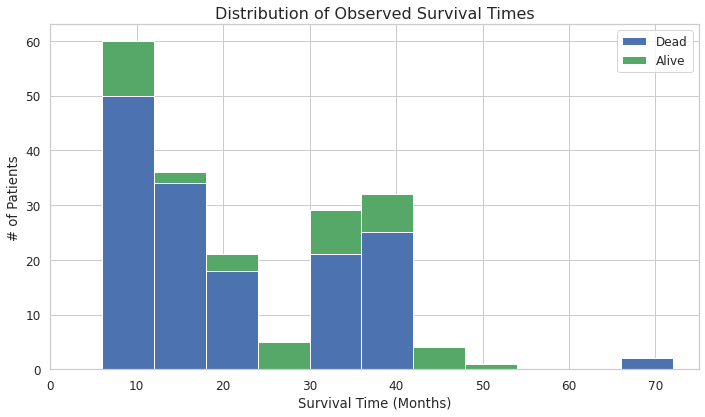

In [27]:
x = df_c[df_c.Outcome == 1]['Survival.Months']
y = df_c[df_c.Outcome == 0]['Survival.Months']
plt.figure(figsize=(10, 6))
plt.hist([x, y], bins=np.arange(0, 73, 6), stacked=True, color=['b', 'g'], label=['Dead', 'Alive'])
plt.legend()
plt.xlabel('Survival Time (Months)')
plt.ylabel('# of Patients')
plt.xlim(0, 75)
plt.title('Distribution of Observed Survival Times', fontsize=16)
plt.tight_layout()

Most of the patients seem to fall into 2 groups for observed survival time: approximately one and three years. It is unclear if knowledge of the true survival times of the censored patients would significantly change this observation.
<br/>

<br/>
The following charts show the surival time distributions of each distinct value of the 5 categorical and ordinal features (missing values are ignored). As before, the plots also indicate whether patients are dead or alive at follow-up.

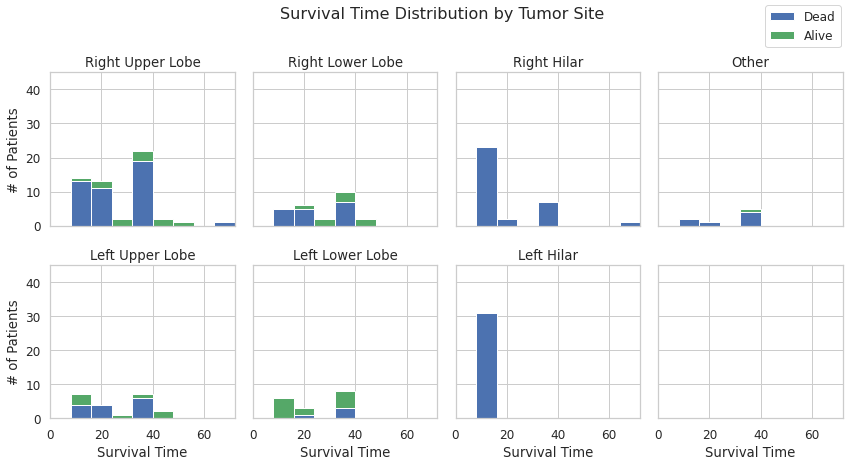

In [28]:
surv_graph(df_c, 'Primary.Site', 'Tumor Site', 2, 4, 12, 6, 0.48, 0.58, 0.52, 1.08)

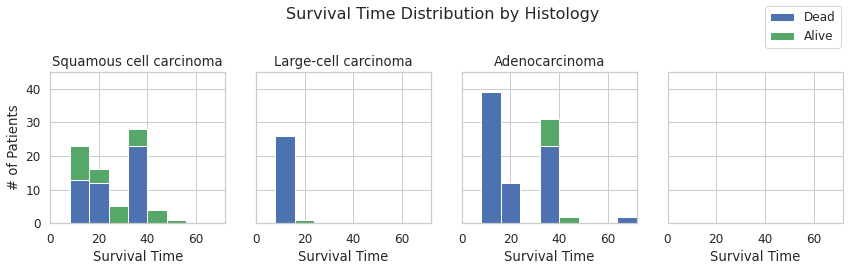

In [29]:
surv_graph(df_c, 'Histology', 'Histology', 1, 4, 12, 3.3, 0.48, 0.64, 0.52, 1.14)

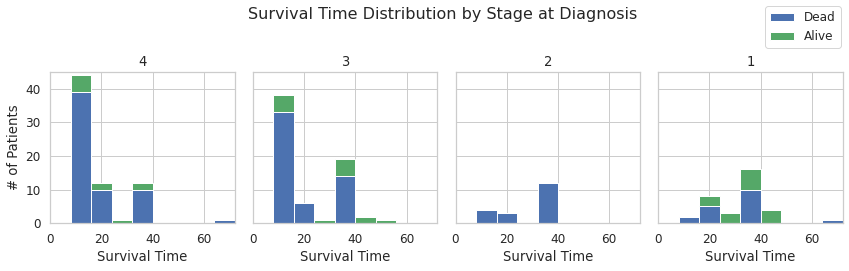

In [30]:
surv_graph(df_c, 'Stage', 'Stage at Diagnosis', 1, 4, 12, 3.3, 0.48, 0.64, 0.52, 1.14)

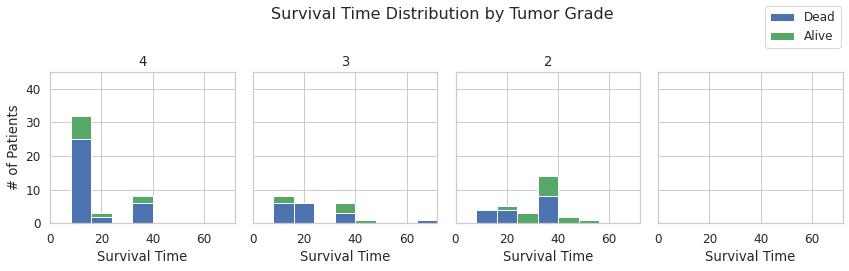

In [31]:
surv_graph(df_c, 'Grade', 'Tumor Grade', 1, 4, 12, 3.3, 0.48, 0.64, 0.52, 1.14)

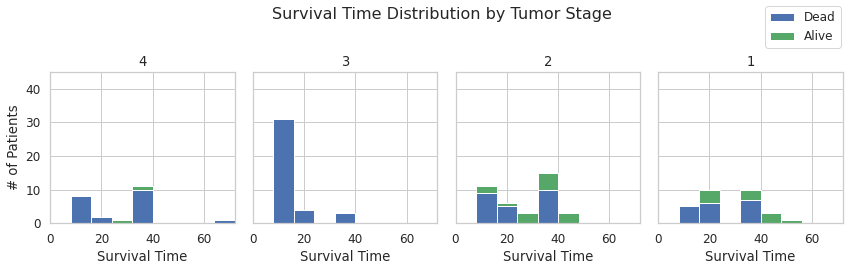

In [32]:
surv_graph(df_c, 'T', 'Tumor Stage', 1, 4, 12, 3.3, 0.48, 0.64, 0.52, 1.14)

From these plots, it is evident that large-cell carcinoma histology and right and left hilar primary tumor site are associated with reduced survival time, while squamous cell carcinoma histology is associated with longer survival. As expected, there is also a clear trend where survival time decreases as tumor stage and grade increase.

<br/><br/>
Here is the correlation matrix heatmap of the clinical data with missing values. I changed the categorical features Primary.Site and Histology (Tumor histology) into dummy variables before creating it so that their correlations would also show.

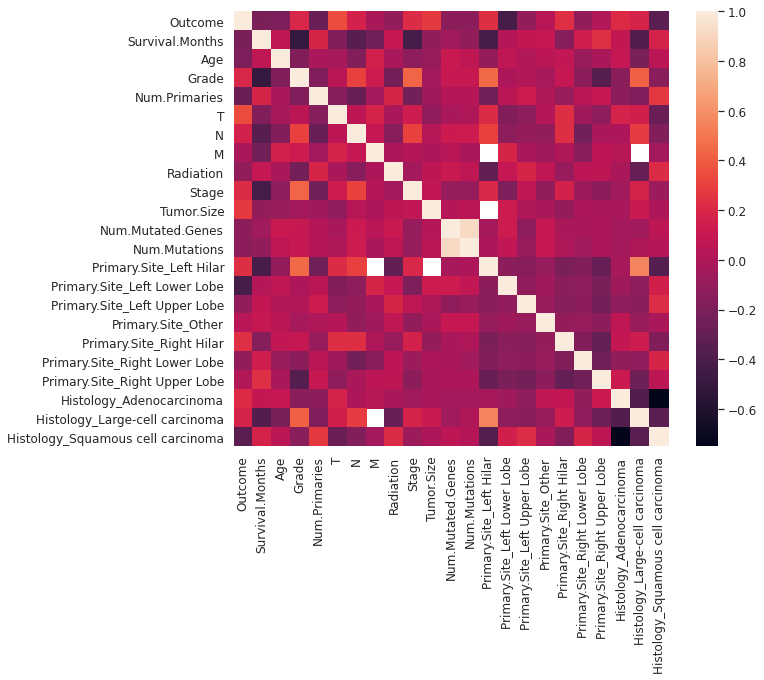

In [33]:
corrmat = pd.get_dummies(df_c).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corrmat, square=True);

In [34]:
# Funtion to create a sorted correlation series
# Correlations between subsets of features are not returned if specified
def corr_series(corrmat, col1_start=False, col1_end=False, col2_start=False, col2_end=False):
    cs = corrmat.where(np.triu(np.ones(corrmat.shape), k=1).astype(np.bool))
    if col1_start and col1_end:
        cs.loc[col1_start:col1_end, col1_start:col1_end] = np.nan
    if col2_start and col2_end:
        cs.loc[col2_start:col2_end, col2_start:col2_end] = np.nan
    return cs.stack().sort_values(ascending=False)

Here is the only clinical feature that is positively correlated with death (r > 0.3).

In [35]:
outlook_corr_c = corrmat['Outcome'].drop('Outcome').sort_values(ascending=False)
outlook_corr_c[outlook_corr_c > .3]

T    0.346382
Name: Outcome, dtype: float64

These are the clinical features that are negatively correlated with death (r < -0.3).

In [36]:
outlook_corr_c[outlook_corr_c < -.3].sort_values()

Primary.Site_Left Lower Lobe        -0.426118
Histology_Squamous cell carcinoma   -0.336315
Name: Outcome, dtype: float64

And these are the clinical features that are negatively correlated with survival time (r < -0.3). Surival time is not positively correlated with any of the clinical features.

In [37]:
months_corr_c = corrmat['Survival.Months'].drop('Survival.Months').sort_values(ascending=False)
months_corr_c[months_corr_c < -.3].sort_values()

Grade                            -0.498487
Stage                            -0.427541
Primary.Site_Left Hilar          -0.416006
Histology_Large-cell carcinoma   -0.373633
N                                -0.346523
Name: Survival.Months, dtype: float64

These are the clinical features that are postively correlated with each other (r > 0.3).

In [38]:
cs = corr_series(corrmat.iloc[2:, 2:], 'Primary.Site_Left Hilar', 'Primary.Site_Right Upper Lobe', 'Histology_Adenocarcinoma',
                 'Histology_Squamous cell carcinoma')
cs[cs > .3]

Num.Mutated.Genes        Num.Mutations                     0.915735
Primary.Site_Left Hilar  Histology_Large-cell carcinoma    0.554587
Grade                    Primary.Site_Left Hilar           0.446945
Grade                    Stage                             0.430301
Grade                    Histology_Large-cell carcinoma    0.412820
N                        Stage                             0.310238
N                        Primary.Site_Left Hilar           0.308295
dtype: float64

And these are the clinical features that are negatively correlated with each other (r < -0.3).

In [39]:
cs[cs < -.3].sort_values()

Primary.Site_Left Hilar  Histology_Squamous cell carcinoma   -0.364492
Grade                    Primary.Site_Right Upper Lobe       -0.354973
Radiation                Primary.Site_Left Hilar             -0.310993
dtype: float64

Unsurprisingly, the strongest positive correlation is between Num.Mutated.Genes (# of genes with mutation) and Num.Mutations (# of mutations in the tumor).<br/><br/>
Tumor stage is the only clinical feature that is positively correlated with death. Meanwhile, tumor grade, stage at diagnosis, left hilar primary site, large cell carcinoma histology, and number of mestastases to lymph nodes are each negatively correlated with survival time. Many of these clinical features are also positively correlated with each other.<br/><br/>
Left lower lobe primary site and squamous cell carcinoma histology are both negatively correlated with death, while none of the clinical features are positively correlated with survival time. Squamous cell carcinoma histology is also negatively correlated with left hilar primary site, which itself has a negative correlation with survival time.

<br/>
Here is the correlation matrix of the entire dataset. Once again, I changed the categorical features Primary.Site and Histology into dummy variables before creating the matrix so that their correlations would show.

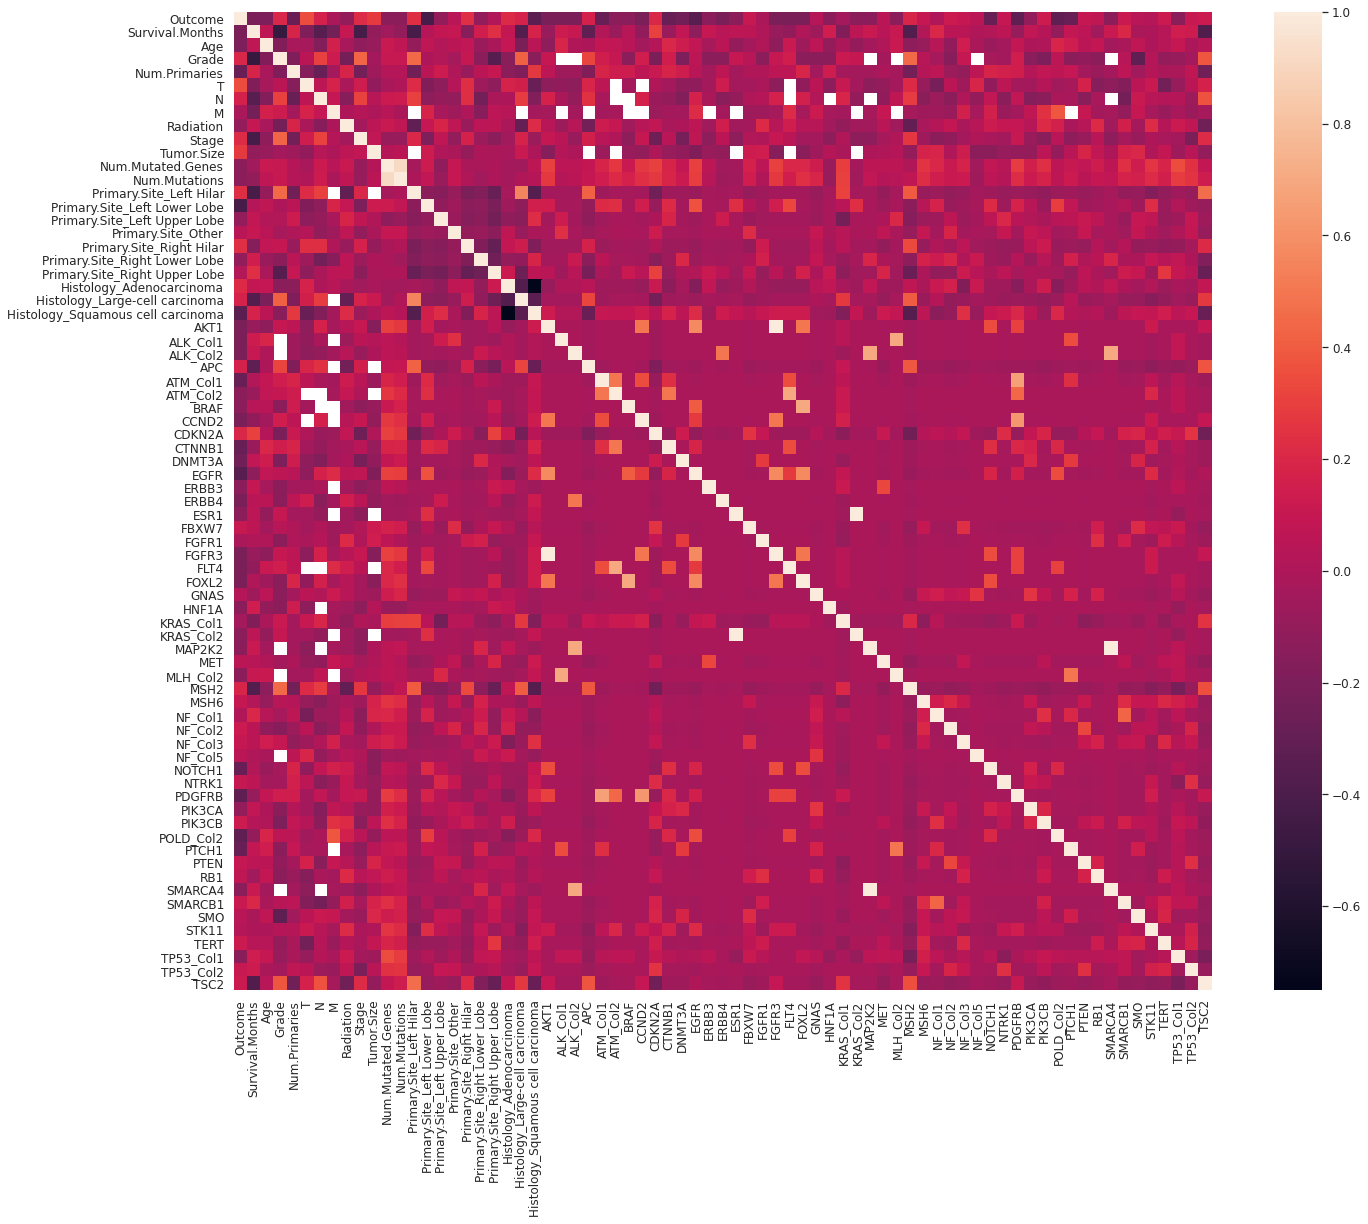

In [40]:
df_c_dumb = pd.get_dummies(df_c)
df_corr = df_c_dumb.join(df_g, how='outer')
df_corr.loc[:,'AKT1':] = df_corr.loc[:,'AKT1':].fillna(0)
corrmat_full = df_corr.corr()
plt.figure(figsize=(22, 18))
sns.heatmap(corrmat_full, square=True);

These are the genomic features that are negatively correlated with survival time (r < 0.3). The frequency of each genetic mutation is also included. Survival time is not positively correlated with any of the genomic features.

In [41]:
months_corr_g = pd.concat([corrmat_full['Survival.Months'].loc['AKT1':].sort_values(ascending=False), freq_g], axis=1)
months_corr_g.columns = ['Correlation', 'Frequency']
months_corr_g[months_corr_g.Correlation <= -.3].sort_values('Correlation')

,Correlation,Frequency
TSC2,-0.383810,31
MSH2,-0.378229,30
APC,-0.313774,19


And these are the genomic features that are negatively correlated with death (r <= -0.3). Death is not positively correlated with any of the genomic features.

In [42]:
outcome_corr_g = pd.concat([corrmat_full['Outcome'].loc['AKT1':].sort_values(ascending=False), freq_g], axis=1)
outcome_corr_g.columns = ['Correlation', 'Frequency']
outcome_corr_g[outcome_corr_g.Correlation <= -.3].sort_values('Correlation')

,Correlation,Frequency
EGFR,-0.349689,6
POLD_Col2,-0.318357,5
PDGFRB,-0.318357,5


These are the genomic features that are positively correlated with clinical features (r > 0.3).

In [43]:
cs_full = corr_series(corrmat_full.iloc[2:, 2:], 'Age', 'Histology_Squamous cell carcinoma', 'AKT1', 'TSC2')

corr_pos = cs_full[cs_full >= .3].reset_index().join(freq_g, on='level_1', how='left').set_index(['level_0', 'level_1'])
corr_pos.columns = ['Correlation', 'Frequency']
corr_pos.index.names = (None, None)
corr_pos

,,Correlation,Frequency
Primary.Site_Left Hilar,TSC2,0.460337,31
Grade,MSH2,0.446945,30
Primary.Site_Left Hilar,APC,0.422561,19
Histology_Large-cell carcinoma,MSH2,0.402509,30
Primary.Site_Left Hilar,MSH2,0.394731,30
Grade,TSC2,0.381300,31
M,POLD_Col2,0.378415,5
Primary.Site_Left Lower Lobe,EGFR,0.365169,6
N,TSC2,0.364366,31
Num.Mutated.Genes,TP53_Col1,0.348781,117


And these are the genomic features that are negatively correlated with clinical features (r < -0.3).

In [44]:
corr_neg = cs_full[cs_full < -.3].reset_index().join(freq_g, on='level_1', how='left').set_index(['level_0', 'level_1'])
corr_neg.columns = ['Correlation', 'Frequency']
corr_neg.index.names = (None, None)
corr_neg.sort_values('Correlation')

,,Correlation,Frequency
Histology_Squamous cell carcinoma,MSH2,-0.357443,30
Grade,SMO,-0.315766,8
Radiation,MSH2,-0.304978,30


Mutations of TSC2, MSH2, and APC are each negatively correlated with survival time, while no genetic mutations are positively correlated with death. These mutations also each have positive correlations with many of the clinical features that are negatively correlated with survival time. Also, a mutation of MSH2 is negatively correlated with Squamous cell carcinoma histology, which itself has a negative correlation with death.

Mutations of EGFR, POLD_Col2, and PDGFRB are each negatively correlated with death, while no genetic mutations are positively correlated with survival time. A mutation of EGFR is also positively correlated with left lower lobe primary site, which itself has a negative correlation with death.
<br/><br/><br/>

Before imputing missing values and performing feature selection, the dataset will be split into train, validation and test sets to prevent data leakage. I will use stratification so that the train, validation and test sets are more likely to be representative of the dataset as a whole. I want each subset to have a similar distribution of values from both Outlook and Survival.Months.<br/><br/>
I put the values of Survival.Months into 3 separate bins divided by the approximate tertile values for 33 and 67 percentile. Then I combine the former labels of the Outcome values ('Alive' and 'Dead') with the new group labels of the Survival.Months values. This will result in each patient being placed in one of 6 distinct groups (Alive-1, Alive-2, Alive-3, Dead-1, Dead-2, and Dead-3). Next, StratifiedShuffleSplit is used to create random train, validation and test indices stratified based on the distributions of the newly created groups. The train, validation and test sets are later created with these indices. The train-validation-test split percentage is 70-15-15.

In [45]:
# Create 6 groups for the patients so that they can be stratified by both Outcome and Survival.Months
months = df.loc[:, 'Survival.Months']
bins = np.array([min(months), months.quantile(1/3), months.quantile(2/3), max(months) + 1])
months_binned = np.digitize(months, bins)
months_binned = pd.Series(months_binned).astype(str)
outcome = df['Outcome'].replace({0: 'Alive', 1: 'Dead'})
patients_grouped = outcome + '-' + months_binned.values

In [46]:
# Distribution of groups
patients_grouped.value_counts()

Dead-2     52
Dead-1     50
Dead-3     48
Alive-3    20
Alive-2    10
Alive-1    10
Name: Outcome, dtype: int64

In [47]:
# Create stratified train, validation and test set indices using StratifiedShuffleSplit twice
sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=88)

for train_index, val_test_index in sss1.split(patients_grouped, patients_grouped):
    pg_val_test = patients_grouped.iloc[val_test_index]
    train_index = train_index + 1    
    
sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=88)

for val_index, test_index in sss2.split(pg_val_test, pg_val_test):
    pg_val = pg_val_test.iloc[val_index]
    pg_test = pg_val_test.iloc[test_index]
    val_index = pg_val.index
    test_index = pg_test.index

The dataset has 3 ordinal features (Grade, T, and Stage) and 2 categorical features (Primary.Site and Histology), and I will create dummy variables for these 5 features before I begin modelling.<br/><br/>
However, there are still missing values within several features (Grade, T, N, M, and Tumor.Size). I will use iterative multivariate feature imputation to fill in the missing values. The imputer will model each feature with missing values as a function of the other features, and then use that estimate for imputation. All of the features must have numerical values before I begin imputation. Neither of the categorical features have missing values, nor does the ordinal variable Stage.<br/><br/>
So, I will first create dummy variables for these 3 features (Stage, Primary.Site, and Histology). I will drop the first category/unique value of each feature, since only k - 1 indicator variables are needed to represent the k categories of a categorial variable.

In [48]:
# Covert 3 features into dummy variables
df = pd.get_dummies(df, columns=['Stage','Primary.Site','Histology'], drop_first=True).copy()

The train, validation and test sets are created with the indices generated previously.

In [49]:
train = df.loc[train_index]
val = df.loc[val_index]
test = df.loc[test_index]

I will keep the target variables (Outcome and Survival.Months) separate while performing imputation, so that the imputed test data is not influenced by this information. The training set is divided into y_train (containing just Outcome and Survival.Months) and X_train which contains the predictor variables. The validation and test sets are split similarly.

In [50]:
X_train = train.drop(['Outcome','Survival.Months'],axis=1)
y_train = train.loc[:, ['Outcome','Survival.Months']]

In [51]:
X_val = val.drop(['Outcome','Survival.Months'],axis=1)
y_val = val.loc[:, ['Outcome','Survival.Months']]

In [52]:
X_test = test.drop(['Outcome','Survival.Months'],axis=1)
y_test = test.loc[:, ['Outcome','Survival.Months']]

The imputer is initialized with a specified random seed for reproducibility. It is then fit on X_train. The imputer then transforms/imputes X_train and the result is assigned to X_train_imputed. The imputer remains fitted on X_train, and the same process of transformation and assingment takes place for both the validation and test set.

In [53]:
imputer = IterativeImputer(random_state=88)

X_train_imputed = X_train.copy()
X_val_imputed = X_val.copy()
X_test_imputed = X_test.copy()

imputer.fit(X_train)

X_train_imputed.iloc[:, :] = imputer.transform(X_train)

X_val_imputed.iloc[:, :] = imputer.transform(X_val)

X_test_imputed.iloc[:, :] = imputer.transform(X_test)

y_train and X_train are joined to form the imputed training set, train_imputed. The imputed validation and test sets are formed in the same way.<br/><br/>
The full imputed data set, df_imputed, is formed by concatenating train_imputed, val_imputed and test_imputed.

In [54]:
train_imputed = y_train.join(X_train_imputed, how='left')
val_imputed = y_val.join(X_val_imputed, how='left')
test_imputed = y_test.join(X_test_imputed, how='left')

# The rows of the resulting DataFrame are sorted
df_imputed = pd.concat([train_imputed, val_imputed, test_imputed]).sort_index()

The imputer imputes values with several decimals, so the imputed values need to be rounded. The values of Tumor.Size are rounded to one decimal, while the remaining imputed features are rounded to integers.

In [55]:
for col in ['Grade','T','N','M']:
    df_imputed.loc[:, col] = df_imputed[col].round()
    
df_imputed.loc[:, 'Tumor.Size'] = df_imputed['Tumor.Size'].round(1)

The value frequencies of the features with missing values are shown both before and after imputation.

In [56]:
for col in missing_cols:
    print('Initial:')
    print(df[col].value_counts(), '\n')
    print('Post-imputation:')
    print(df_imputed[col].value_counts(), '\n')

Initial:
4.0    43
2.0    29
3.0    22
Name: Grade, dtype: int64 

Post-imputation:
3.0    84
4.0    65
2.0    41
Name: Grade, dtype: int64 

Initial:
3.0    38
2.0    38
1.0    29
4.0    23
Name: T, dtype: int64 

Post-imputation:
2.0    100
3.0     38
1.0     29
4.0     23
Name: T, dtype: int64 

Initial:
2.0    58
0.0    52
1.0     9
3.0     6
Name: N, dtype: int64 

Post-imputation:
2.0    68
1.0    64
0.0    52
3.0     6
Name: N, dtype: int64 

Initial:
0.0    86
1.0     8
Name: M, dtype: int64 

Post-imputation:
0.0    182
1.0      8
Name: M, dtype: int64 

Initial:
2.0     20
1.5     13
9.0     10
3.6      9
10.0     8
4.0      7
5.5      6
8.5      6
3.5      2
8.0      2
1.8      2
1.4      2
1.9      2
5.4      2
5.3      2
2.5      2
1.0      1
4.4      1
1.6      1
Name: Tumor.Size, dtype: int64 

Post-imputation:
4.6     92
2.0     20
1.5     13
9.0     10
3.6      9
10.0     8
4.0      7
5.5      6
8.5      6
3.5      2
8.0      2
1.8      2
1.4      2
1.9      2
5.4     

In [57]:
# Change the value type of 2 columns
df_imputed.loc[:, ['Grade','T']] = df_imputed.loc[:, ['Grade','T']].astype(np.int64)

Two ordinal values orginally contained missing values, and they have been imputed. I will now create dummy variables for these features (Grade and T), dopping the first unique value of each feature.

In [58]:
df_imputed = pd.get_dummies(df_imputed, columns=['Grade','T'], drop_first=True)

# Change all values types to float
df_imputed = df_imputed.astype(np.float64)

There are now 76 variables in the dataset due to the creation of several dummy/indicator variables.

In [59]:
train.shape[1]

73

In [60]:
df_imputed.head()

,Outcome,Survival.Months,Age,Num.Primaries,N,M,Radiation,Tumor.Size,Num.Mutated.Genes,Num.Mutations,AKT1,ALK_Col1,ALK_Col2,APC,ATM_Col1,ATM_Col2,BRAF,CCND2,CDKN2A,CTNNB1,DNMT3A,EGFR,ERBB3,ERBB4,ESR1,FBXW7,FGFR1,FGFR3,FLT4,FOXL2,GNAS,HNF1A,KRAS_Col1,KRAS_Col2,MAP2K2,MET,MLH_Col2,MSH2,MSH6,NF_Col1,NF_Col2,NF_Col3,NF_Col5,NOTCH1,NTRK1,PDGFRB,PIK3CA,PIK3CB,POLD_Col2,PTCH1,PTEN,RB1,SMARCA4,SMARCB1,SMO,STK11,TERT,TP53_Col1,TP53_Col2,TSC2,Stage_2,Stage_3,Stage_4,Primary.Site_Left Lower Lobe,Primary.Site_Left Upper Lobe,Primary.Site_Other,Primary.Site_Right Hilar,Primary.Site_Right Lower Lobe,Primary.Site_Right Upper Lobe,Histology_Large-cell carcinoma,Histology_Squamous cell carcinoma,Grade_3,Grade_4,T_2,T_3,T_4
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,9.0,67.0,0.0,2.0,0.0,0.0,1.4,8.0,8.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
2,1.0,19.0,73.0,0.0,2.0,0.0,1.0,4.6,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,13.0,72.0,0.0,2.0,0.0,0.0,1.5,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,1.0,15.0,69.0,1.0,0.0,1.0,0.0,4.6,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5,1.0,10.0,76.0,0.0,1.0,0.0,0.0,4.6,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


In [61]:
df_imputed.describe()

,Outcome,Survival.Months,Age,Num.Primaries,N,M,Radiation,Tumor.Size,Num.Mutated.Genes,Num.Mutations,AKT1,ALK_Col1,ALK_Col2,APC,ATM_Col1,ATM_Col2,BRAF,CCND2,CDKN2A,CTNNB1,DNMT3A,EGFR,ERBB3,ERBB4,ESR1,FBXW7,FGFR1,FGFR3,FLT4,FOXL2,GNAS,HNF1A,KRAS_Col1,KRAS_Col2,MAP2K2,MET,MLH_Col2,MSH2,MSH6,NF_Col1,NF_Col2,NF_Col3,NF_Col5,NOTCH1,NTRK1,PDGFRB,PIK3CA,PIK3CB,POLD_Col2,PTCH1,PTEN,RB1,SMARCA4,SMARCB1,SMO,STK11,TERT,TP53_Col1,TP53_Col2,TSC2,Stage_2,Stage_3,Stage_4,Primary.Site_Left Lower Lobe,Primary.Site_Left Upper Lobe,Primary.Site_Other,Primary.Site_Right Hilar,Primary.Site_Right Lower Lobe,Primary.Site_Right Upper Lobe,Histology_Large-cell carcinoma,Histology_Squamous cell carcinoma,Grade_3,Grade_4,T_2,T_3,T_4
count,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000
mean,0.789474,22.186842,70.173684,0.226316,1.147368,0.042105,0.331579,4.545789,2.684211,3.084211,0.010526,0.010526,0.010526,0.100000,0.021053,0.005263,0.005263,0.010526,0.236842,0.021053,0.015789,0.031579,0.005263,0.010526,0.005263,0.042105,0.021053,0.010526,0.010526,0.010526,0.036842,0.005263,0.289474,0.005263,0.005263,0.047368,0.005263,0.157895,0.036842,0.026316,0.052632,0.036842,0.010526,0.021053,0.036842,0.026316,0.036842,0.057895,0.026316,0.021053,0.036842,0.021053,0.005263,0.047368,0.042105,0.121053,0.052632,0.615789,0.042105,0.163158,0.100000,0.352632,0.368421,0.089474,0.110526,0.042105,0.173684,0.131579,0.289474,0.142105,0.405263,0.442105,0.342105,0.526316,0.200000,0.121053
std,0.408760,12.420140,6.146909,0.419551,0.860275,0.201360,0.472024,2.186359,1.460327,1.697575,0.102326,0.102326,0.102326,0.300793,0.143939,0.072548,0.072548,0.102326,0.426268,0.143939,0.124990,0.175338,0.072548,0.102326,0.072548,0.201360,0.143939,0.102326,0.102326,0.102326,0.188872,0.072548,0.454716,0.072548,0.072548,0.212987,0.072548,0.365606,0.188872,0.160496,0.223887,0.188872,0.102326,0.143939,0.188872,0.160496,0.188872,0.234161,0.160496,0.143939,0.188872,0.143939,0.072548,0.212987,0.201360,0.327050,0.223887,0.487693,0.201360,0.370486,0.300793,0.479052,0.483651,0.286180,0.314373,0.201360,0.379839,0.338926,0.454716,0.350081,0.492240,0.497949,0.475668,0.500626,0.401057,0.327050
min,0.000000,9.000000,56.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,11.000000,67.000000,0.000000,0.000000,0.000000,0.000000,3.600000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000

The train, validation and test sets are taken from the current version of the dataset, df_imputed, by using their indices.

In [62]:
train = df_imputed.loc[train.index].copy()
val = df_imputed.loc[val.index].copy()
test = df_imputed.loc[test.index].copy()

## Feature Selection

I will first use filter methods (variance threshold and variance inflation factor) to remove features. During modelling I will further remove features with the embedded method, elastic net regularization. I will only analyze the training set (not the validation or test set) when performing feature selection so that there is no data leakage. <br/><br/>
Quasi-constant features are considered to have less predictive power. Several of the genetic mutations occur in a very small number of patients. I have decided to remove the genomic features that occur in less than 3 of the 133 patients in the training set. This represents a variance cut-off of less than 0.022 for the binary features.

In [63]:
# Low variance genomic features within the training set
train_g = train[df_g.columns]
var_train_g = train_g.var().sort_values()
low_var_features = var_train_g[var_train_g < .022].index.tolist()
low_var_features

['HNF1A',
 'NF_Col5',
 'MLH_Col2',
 'CCND2',
 'ERBB3',
 'AKT1',
 'FGFR3',
 'BRAF',
 'KRAS_Col2',
 'ATM_Col2',
 'FLT4',
 'ESR1',
 'SMARCA4',
 'MAP2K2',
 'DNMT3A',
 'ALK_Col1',
 'FOXL2',
 'ERBB4',
 'ALK_Col2']

In [64]:
# Remove low variance features
train.drop(columns=low_var_features, inplace=True)
val.drop(columns=low_var_features, inplace=True)
test.drop(columns=low_var_features, inplace=True)

57 variables now remain from the original 76. This includes several dummy/indicator variables and the target variables.

In [65]:
train.shape

(133, 57)

I will now use variance inflation factor to detect multicolinearity within the features (independent variables).

X_train contains only the feature variables of the training set.

In [66]:
X_train = train.iloc[:, 2:]

In [67]:
# Returns freatures with VIF greater than threshold
def VIF(data, threshold):
    data = add_constant(data)
    for i in range(1, data.shape[1]):
        vif = variance_inflation_factor(data.values, i)
        if vif > threshold:
            return str(data.columns[i]) + ': ' + str(vif)
    return 'No variables have a VIF greater than ' + str(threshold)

The variance inflation factor of Num.Mutated.Genes is far too high, so I will remove it as a feature.

In [68]:
VIF(X_train, 10)

'Num.Mutated.Genes: 23.852365777473704'

In [69]:
# Remove feature with high VIF
train.drop(columns='Num.Mutated.Genes', inplace=True)
val.drop(columns='Num.Mutated.Genes', inplace=True)
test.drop(columns='Num.Mutated.Genes', inplace=True)
X_train = train.iloc[:, 2:]

There are no longer any features with a high VIF.

In [70]:
VIF(X_train, 10)

'No variables have a VIF greater than 10'

54 features now remain in the dataset after using two filter methods.

In [71]:
X_train.shape[1]

54

## Model Selection and Assessment

I have chosen to use elastic net penalized Cox proportional hazards regression to model the data. Cox proportional hazards regression is one of the most popular regression techniques for survival analysis. It is used to simultaneously relate multiple risk factors to survival time. Unlike linear regression, it is capable of handling right censored event times (when a patient does not die during the study), which this dataset contains. The elastic net penalty will reduce many of the predictor variable coefficents to zero, performing embedded feature selection.

The two hyperparameters of the elastic net penalty, the penalty strength parameter and the L1 ratio, need to be tuned to create the optimal model. In order to do this, I will fit many different models to the training data, each with different values of the hyperperameters. For each model, I will calculate the concordance-index and average partial log-likelihood of the train set. Each model will be evaluated on the validation set using the same metrics. The number of non-zero predictor variable coefficients will also be calculated. I will then move forward with the model with the best combination of validation set scores.

The model coefficients, hyperparameters and validation scores for each model are placed into 2 dictionaries (params and scores).

In [74]:
params = {}
scores = {'penalty': [], 'l1_ratio': [], 'c_index_train': [], 'log_like_train': [], 'c_index_test': [], 'log_like_test': []}

for p in np.linspace(.05, 1, 39):
    for l in np.linspace(.05, 1, 39):
        cph = CoxPHFitter(l1_ratio=l, penalizer=p).fit(train, 'Survival.Months', 'Outcome')
        params[(p, l)] = cph.params_
        scores['penalty'].append(p)
        scores['l1_ratio'].append(l)
        scores['c_index_train'].append(cph.concordance_index_)
        scores['log_like_train'].append(cph.score(train))
        scores['c_index_test'].append(cph.score(val, scoring_method='concordance_index'))
        scores['log_like_test'].append(cph.score(val)) 

In [75]:
# Convert scores dictionary to a DataFrame
df_scores = pd.DataFrame.from_dict(scores)

The params dictionary containing the covariant (predictor) coefficients of each model is converted into a list containing the number of non-zero coefficients of each model. It is then converted into a Series and finally joined with the df_scores DataFrame to form a new DataFrame, df_validation.

In [76]:
fc_list = []
for v in params.values():
    fc_list.append(sum([1 if abs(x) >= .01 else 0 for x in v.tolist()]))
    
fc_series = pd.Series(np.array(fc_list), name='feature_count')
df_validation = df_scores.join(fc_series, how='left')

In [77]:
df_validation.head()

,penalty,l1_ratio,c_index_train,log_like_train,c_index_test,log_like_test,feature_count
0,0.05,0.050,0.874406,-2.503466,0.763889,-1.716583,53
1,0.05,0.075,0.874703,-2.504124,0.763889,-1.715155,52
2,0.05,0.100,0.874555,-2.504807,0.763889,-1.713777,52
3,0.05,0.125,0.873961,-2.505515,0.763889,-1.712460,52
4,0.05,0.150,0.873812,-2.506248,0.760417,-1.711190,52


This function takes df_validation and plots the values of a specified column versus the 2 hyperparameters in a 3D graph.

In [78]:
def coxph_tune_3d(df, test_str, z_label_str, title_str, rotation=45, x_padding=6, y_padding=6, z_padding=6, z_tick_padding=4):
    df_3d = df.loc[:, ['penalty','l1_ratio', test_str]].copy()
    df_3d.columns=['X','Y','Z']

    fig = plt.figure(figsize=(12, 8))
    ax = fig.gca(projection='3d')
    surf=ax.plot_trisurf(df_3d['X'], df_3d['Y'], df_3d['Z'], cmap=plt.cm.viridis, linewidth=0.3)
    fig.colorbar(surf, shrink=0.5, aspect=6)
    ax.view_init(azim=rotation)
    ax.set_xlabel('Penalty Strength', labelpad=x_padding)
    ax.set_ylabel('L1 Ratio', labelpad=y_padding)
    ax.zaxis.set_rotate_label(False)
    ax.set_zlabel(z_label_str, rotation=90, labelpad=z_padding)
    ax.set_title(title_str, fontsize=16, pad=40)
    ax.tick_params(axis='z', pad=z_tick_padding)
    
    fig.tight_layout()

The following 3D graphs show both training and validaiton scores for different combinations of the 2 hyperparameters, penalty strength and L1 ratio.<br/><br/>
L1 is lasso regularization, while L2 is ridge regularization. While both methods reduce the magnitude of coefficents in regression, lasso regularization is much more likely to result in zero-value feature coefficients (feature selection). Elastic net regression combines both L1 and L2 regularization. The L1 ratio determines the amount of L1 regularization vs. L2 regularization. Meanwhile, the penalty strength parameter determines the total amount of regularization to apply to the regression.<br/><br/>
The concordance index evaluates the accuracy of the ranking/order of predicted times of patients. A concordance index of 0.5 is the expected result from random predictions, while 1 is a perfect score. Maximum likelihood estimation is a method of estimating the parameters of a model by maximizing a likelihood function, so that under the assumed model the observed data is most probable. The log-likelihood function, which is maximized during the fitting of the model, is used to derive the maximum likelihood estimator. The greater the log-likelihood, the better.

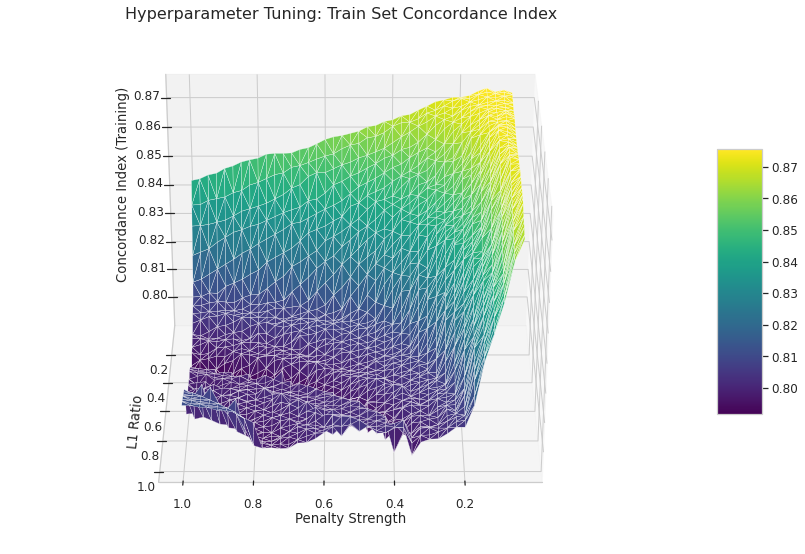

In [79]:
coxph_tune_3d(df_validation, 'c_index_train', 'Concordance Index (Training)',
              'Hyperparameter Tuning: Train Set Concordance Index', 90, z_padding=22, z_tick_padding=10)

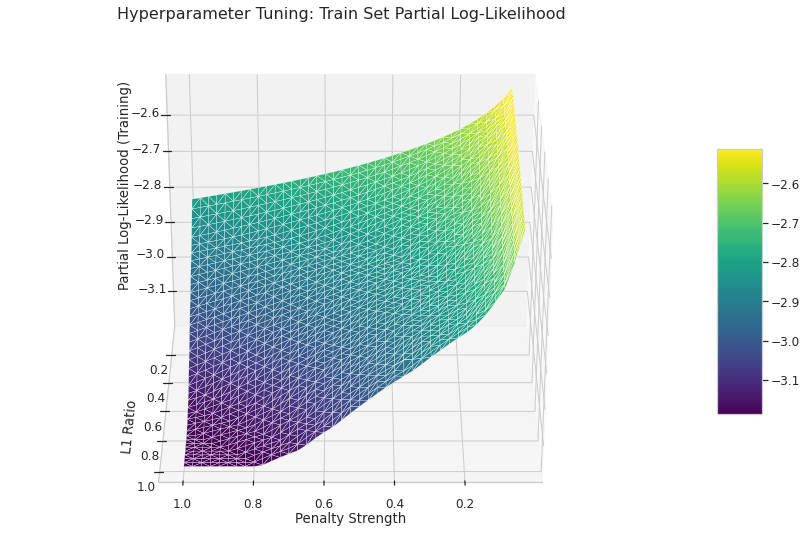

In [80]:
coxph_tune_3d(df_validation, 'log_like_train', 'Partial Log-Likelihood (Training)',
              'Hyperparameter Tuning: Train Set Partial Log-Likelihood', 90, y_padding=12, z_padding=21, z_tick_padding=12)

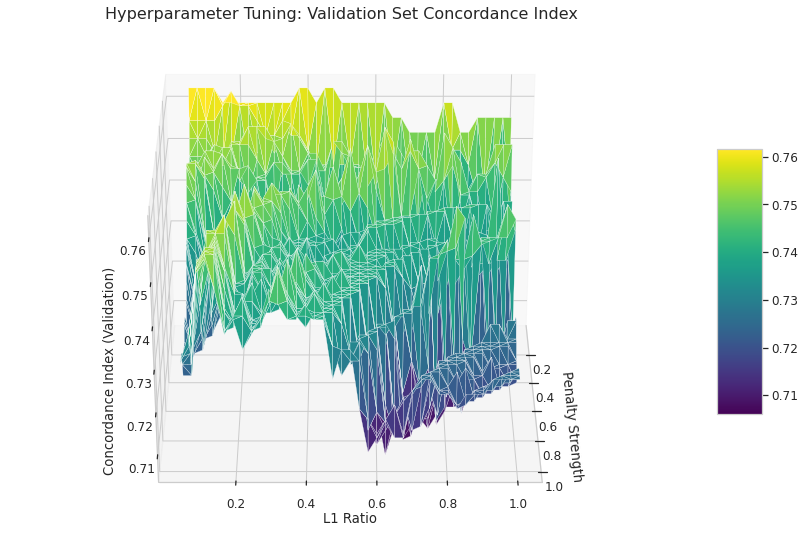

In [81]:
coxph_tune_3d(df_validation, 'c_index_test', 'Concordance Index (Validation)',
              'Hyperparameter Tuning: Validation Set Concordance Index', 0, x_padding=12, z_padding=12)

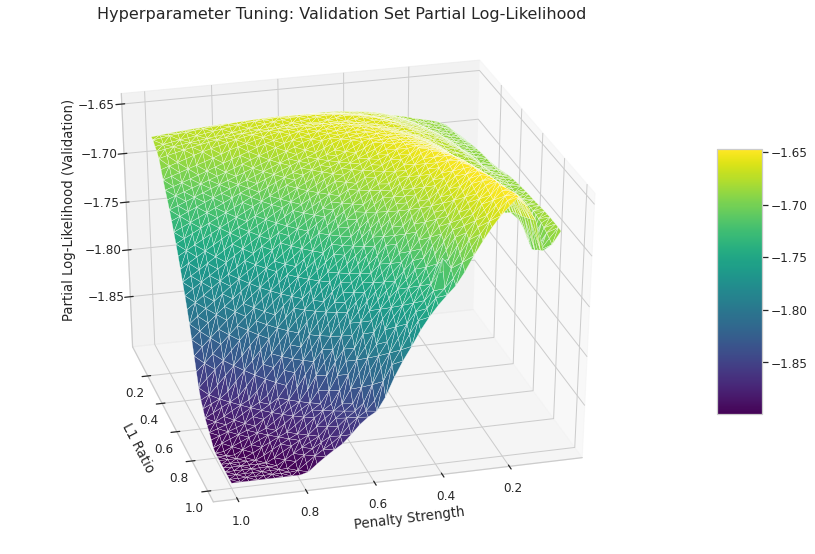

In [82]:
coxph_tune_3d(df_validation, 'log_like_test', 'Partial Log-Likelihood (Validation)', 
              'Hyperparameter Tuning: Validation Set Partial Log-Likelihood', 75, 8, 8, z_padding=21, z_tick_padding=10)

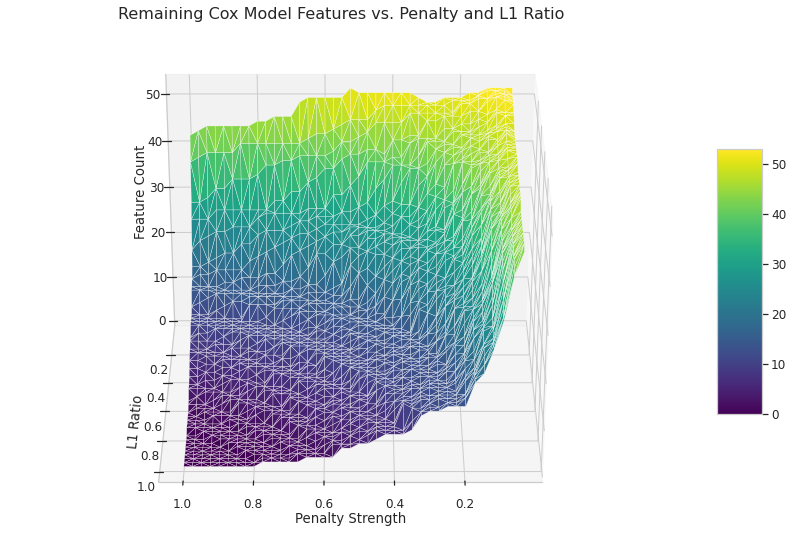

In [83]:
coxph_tune_3d(df_validation, 'feature_count', 'Feature Count',
              'Remaining Cox Model Features vs. Penalty and L1 Ratio', 90)

All of the models produced excellent concordance index scores. Fitted survival models typically have a concordance index of between 0.55 and 0.75, and every one of my models scored better than 0.70 for both the training and validation sets.<br/><br/>
The plots show that the validation scores tend to decrease as the amount of regularization increases. However, as the amount of regularization increases, the model complexity also tends to decrease. Hyperparameters will be chosen to balance these competing properties.<br/><br/>
I have decided on an L1 ratio of 0.65 and a penalty strength of 0.25 for my hyperparameters. My chosen model rates in the 97th percentile among the models in validation set concordance index. It also rates in the 99th percentile in validation set average partial log-likelihood. The latter figure is particularly important, since the out-of-sample log-likelihood score is considered by many to be the best measure of the predictive power of a survival regression model.

In [84]:
l1 = 0.65
pen = 0.25

model_scores = df_validation[(df_validation.penalty > pen -.01) & (df_validation.penalty < pen + .01) &
                      (df_validation.l1_ratio > l1 - .01) & (df_validation.l1_ratio < l1 + .01)]
model_scores

,penalty,l1_ratio,c_index_train,log_like_train,c_index_test,log_like_test,feature_count
336,0.25,0.65,0.818141,-2.801288,0.756944,-1.64922,18


In [85]:
df_validation.describe()

,penalty,l1_ratio,c_index_train,log_like_train,c_index_test,log_like_test,feature_count
count,1521.000000,1521.000000,1521.000000,1521.000000,1521.000000,1521.000000,1521.000000
mean,0.525000,0.525000,0.821352,-2.872160,0.736301,-1.722307,20.369494
std,0.281458,0.281458,0.026112,0.169098,0.011147,0.073190,15.793119
min,0.050000,0.050000,0.791271,-3.186952,0.704861,-1.899276,0.000000
25%,0.275000,0.275000,0.800920,-2.988290,0.729167,-1.755444,8.000000
50%,0.525000,0.525000,0.807304,-2.865752,0.736111,-1.688988,14.000000
75%,0.775000,0.775000,0.843824,-2.757606,0.743056,-1.669173,31.000000
max,1.000000,1.000000,0.876039,-2.503466,0.763889,-1.644755,53.000000


These are the percentiles of my chosen model for each metric.

In [86]:
for col in df_validation.iloc[:, 2:]:
    p = percentileofscore(df_validation[col], model_scores[col].values)
    print(col + ': ' + str(round(p, 2)))

c_index_train: 60.91
log_like_train: 66.34
c_index_test: 97.11
log_like_test: 98.88
feature_count: 57.99


In [87]:
# The validation scores of the models with an L1 ratio of 0.65
df_l1 = df_validation[(df_validation['l1_ratio'] > l1 - .01) & (df_validation['l1_ratio'] < l1 + .01)]

In [88]:
# DataFrame containing the feature coefficents and penalty strength values of the models with an L1 ratio of 0.65
df_feature_l1 = pd.DataFrame(params).T.reset_index()
df_feature_l1 = df_feature_l1[(df_feature_l1['level_1'] > l1 - .01) & (df_feature_l1['level_1'] < l1 + .01)]
df_feature_l1.set_index('level_0', inplace=True)
df_feature_l1.drop(columns='level_1', inplace=True)

The following graphs show how the various metrics vary among the models with an L1 ratio of 0.65 as the penalty strength changes. The power of elastic net regularization as a tool for feature selection is on full display in the first chart.

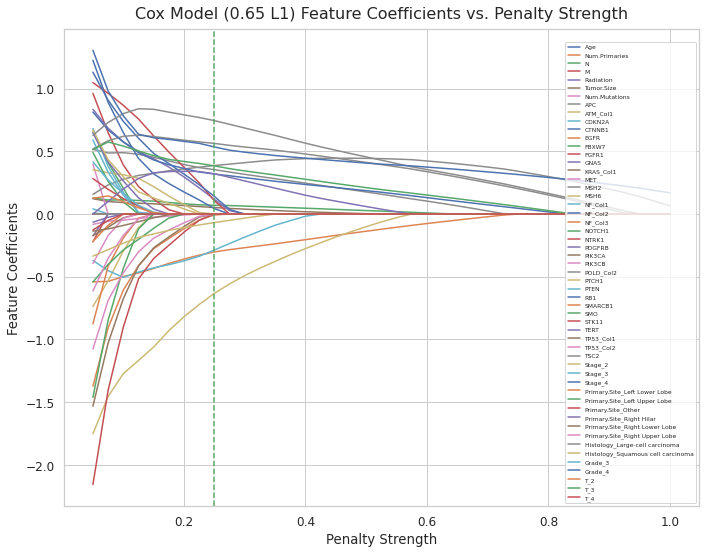

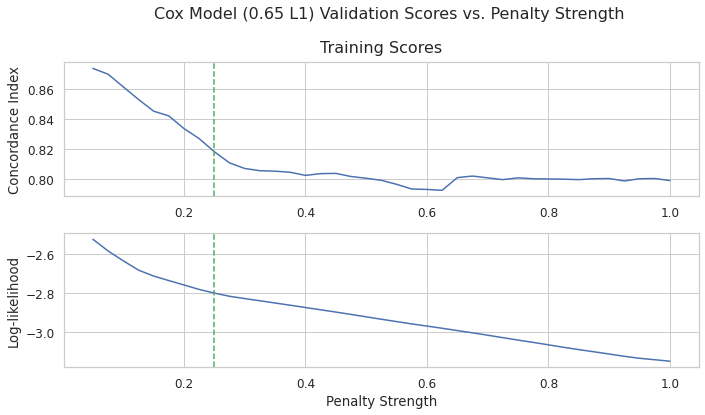

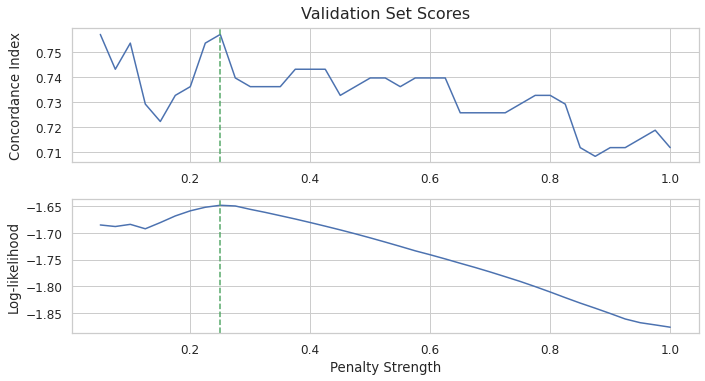

In [89]:
df_feature_l1.plot(figsize=(10, 8))
plt.legend(loc=4, prop={'size': 6})
plt.axvline(pen, color='g', linestyle='--')
plt.xlabel('Penalty Strength')
plt.ylabel('Feature Coefficients')
plt.title('Cox Model (' + str(l1) + ' L1) Feature Coefficients vs. Penalty Strength', fontsize=16, pad=10)

plt.tight_layout()

plt.show()

fig, ax = plt.subplots(figsize=(10, .1))
ax.set_visible(False)

plt.show()

fig1 = plt.figure(figsize=(10, 5.5))

fig1.suptitle('Cox Model (' + str(l1) + ' L1) Validation Scores vs. Penalty Strength', fontsize=16, x=.55, y=1.05)

ax1 = fig1.add_subplot(2, 1, 1)
ax1 = sns.lineplot(x='penalty', y='c_index_train', data=df_l1, legend=False)
ax1.axvline(pen, color='g', linestyle='--')
ax1.set_xlabel(None)
ax1.set_ylabel('Concordance Index', labelpad=6)
ax1.set_title('Training Scores', fontsize=16, pad=10)

ax2 = fig1.add_subplot(2, 1, 2)
ax2 = sns.lineplot(x='penalty', y='log_like_train', data=df_l1, legend=False)
ax2.axvline(pen, color='g', linestyle='--')
ax2.set(xlabel='Penalty Strength', ylabel='Log-likelihood')

fig1.tight_layout()

plt.show()

fig2, ax = plt.subplots(figsize=(10, .1))
ax.set_visible(False)

plt.show()

fig3 = plt.figure(figsize=(10, 5.5))

ax3 = fig3.add_subplot(2, 1, 1)
ax3 = sns.lineplot(x='penalty', y='c_index_test', data=df_l1, legend=False)
ax3.axvline(pen, color='g', linestyle='--')
ax3.set_xlabel(None)
ax3.set_ylabel('Concordance Index', labelpad=12)
ax3.set_yticks(np.linspace(.71, .75, 5))
ax3.set_title('Validation Set Scores', fontsize=16, pad=10)

ax4 = fig3.add_subplot(2, 1, 2)
ax4 = sns.lineplot(x='penalty', y='log_like_test', data=df_l1, legend=False)
ax4.axvline(pen, color='g', linestyle='--')
ax4.set(xlabel='Penalty Strength', ylabel='Log-likelihood')

fig3.tight_layout()

plt.show()

These plots once again show that both the model complexity and validation scores tend to decrease as regularization increases.

<br/>
Now I fit my chosen model to the training set again.

In [90]:
cph = CoxPHFitter(penalizer=pen, l1_ratio=l1).fit(train, 'Survival.Months', 'Outcome')

The proportional hazard assumption of the Cox model is that all patients have the same hazard function, but with a unique scaling factor in front. The hazard function gives the probability of death occuring at time t, given the patient is still alive at time t. This assumption means that the hazard function is the same shape for every patient, but scaled differently. My model does not violate the proportional hazard assumption.

In [91]:
cph.check_assumptions(train, p_value_threshold=0.025, show_plots=True)

Proportional hazard assumption looks okay.


This graph shows all of the feature coefficients of the model. TSC2 has a coefficient of about 0.56. $e^{0.56} = 1.75$. The interpretation is that a patient with a mutation of this gene has a hazard rate of 1.75 times that of a patient without the mutation at all times.<br/><br/>
From this graph you can discern the important features of the model, as well as the many features that were eliminated by elastic net regularization.

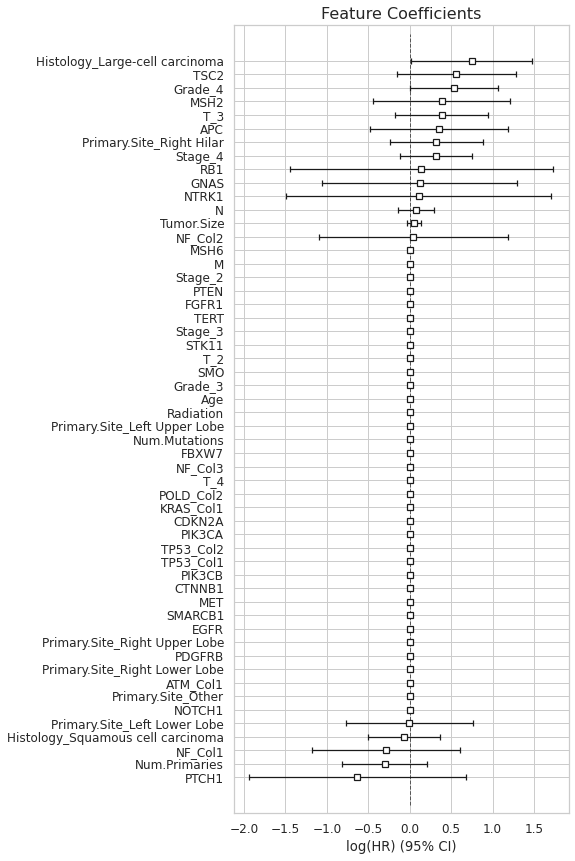

In [92]:
plt.figure(figsize=(6, 14.5))
plt.title('Feature Coefficients', fontsize=16)
cph.plot();

Now the features with zero coefficients can be removed.

features is a Series containing the coefficients of all the features sorted in descending order, just like the plot.

In [93]:
features = cph.params_.sort_values(ascending=False)

There are several dummy variables with zero coefficients. It is my understanding that the dummy variables of a given categorial/ordinal variable should be kept or removed as a group. So, I will not remove these features.

In [94]:
# Assign the non-dummy features with zero coefficients to zero_features
zero_features = features.loc['MSH6':'NOTCH1']

dummy_features = ['Stage_2','Stage_3','Grade_3','Primary.Site_Left Upper Lobe','Primary.Site_Right Upper Lobe',
                  'Primary.Site_Right Lower Lobe','Primary.Site_Other','T_2','T_4']

zero_features.drop(labels=dummy_features, inplace=True)

The features with zero coefficients (not including the dummy variables) are removed from the train, validation and test sets. The new train, validation and test sets are named train_final, val_final, and test_final.

In [95]:
train_final = train.drop(zero_features.index, axis=1).copy()
val_final = val.drop(zero_features.index, axis=1).copy()
test_final = test.drop(zero_features.index, axis=1).copy()

The final model has 30 variables, 28 of which are predictors. 16 of the predictors are dummy variables which represent 5 categorical/ordinal variables. So after performing feature selection, only 17 features remain from a dataset that originally had 63.

In [96]:
train_final.shape[1]

30

Now I fit the final model on the train set. The only change was the removal of features that had no impact on the model, so the validation set concordance index and average partial log-likelihood will remain the same.

In [97]:
cph_final = CoxPHFitter(penalizer=pen, l1_ratio=l1).fit(train_final, 'Survival.Months', 'Outcome')

There are some difficulties in determining the most important features of the model. The interpretation of the coefficients is complicated by the fact that there are 3 different types of variables in the feature set (binary, non-binary, and categorical indicators).

Under the Cox proportional hazard model, the hazard of a patient at time t is equal to the baseline hazard at time t multiplied by the partial hazard of the patient:

$h(t|x) = b_0(t)$ $exp \left( \sum_{i=1}^n b_i(x_i - \bar{x_i}) \right)$

For a covariate $x_i$ and its coefficient $b_i$, the hazard ratio is given by $e^{b_i}$.<br/><br/>
For a given binary covariate $x_i$, the hazard ratio is the ratio of the hazard of a patient with $x_i = 1$ to the hazard of a patient with $x_i = 0$, assuming all other covariates are the same.

Meanwhile, for a non-binary numeric covariate $x_i$, the hazard ratio is defined as the ratio of the hazard of a patient with $x_i = k + 1$ to the hazard of a patient with $x_i = k$, given the other covariates are the same. In other words, it is the factor by which the baseline hazard will increase due to a one unit increase in $x_i$.

Lastly, for a categorical indicator variable $x_i$, the hazard ratio is defined as the ratio of the hazard of a patient (in the category that $x_i$ represents), to the hazard of a patient in the reference category (the dropped category that is considered present when all of its associated indicator variables have zero values), assuming all other covariates are the same.

Tumor.Size and N (# of metastases to lymph nodes) are the only non-binary numeric features remaining. It is possible that their coefficients and resulting hazard ratios underestimate the influence they have on the model. This is because their values are unscaled. I will now scale the values of Tumor.Size and N to unit size, and for each I will solve for the new coefficent that produces the same log-partial hazards with the scaled values. The new coefficient of each covariate can then be compared more appropriately to the coefficients of the others.

In [98]:
# Derive the coefficient of a covariate when its values are unit scaled
def scaled_cox_coeff(train_set, model, covar_str): 
    t_size_series = train_set[covar_str].reset_index(drop=True)
    t_size_mean = t_size_series.mean()
    t_size_coeff = model.params_[covar_str]

    # Create log-partial hazards for each patient
    t_size_lph = t_size_coeff * (t_size_series - t_size_mean)

    # Scale the data
    scaler = MinMaxScaler()
    t_size_scaled = scaler.fit_transform(t_size_series.values.reshape(-1, 1))
    t_list = map(lambda x: x[0], t_size_scaled)
    t_size_scaled = pd.Series(t_list)

    t_size_scaled_mean = t_size_scaled.mean()

    # Solve for the coefficients given the log-partial hazards and scaled data
    t_coeff_series = b_series = t_size_lph/ (t_size_scaled - t_size_scaled_mean)

    # Select the first value. The values are all the same, as they should be.
    return t_coeff_series[0]

In [99]:
scaled_cox_coeff(train_final, cph_final, 'Tumor.Size')

0.4648724711452005

In [100]:
scaled_cox_coeff(train_final, cph_final, 'N')

0.2094111369303277

After scaling the data, the coefficient for Tumor.Size increased from 0.052 to 0.465, while the coefficient for N increased from 0.070 to 0.209. Likewise, the hazard ratio of Tumor.Size increased from 1.053 to 1.592, while the hazard ratio of N increased from 1.073 to 1.232. Therefore, these features have far more impact on the model than was originally thought.<br/><br/>
When looking at the hazard ratios of binary covariates, it is immediately clear whether the positive class increases or decreases the hazard function. The factor by which one class improves or worsens the hazard function relative to the other is also readily apparent. The hazard ratio is probably the best metric by which to assess the importance of a feature in relation to others, because it shows the amount by which the feature single-handedly changes the survival likelihood when its value changes. What cannot be readily determined is the amount by which each value changes the baseline hazard, and consequently the baseline survival curve, although it can be calculated (the partial hazard of each value) relatively easily.<br/><br/>
Categorical covariates are not always as easy to interpret by looking at hazard ratios. Features consisting of k distinct categories are generally converted into k-1 dummy/indicator binary variables so that they can be analayzed numerically. The category not included by name (the reference category), which is often chosen randomly, becomes the category to which the indicator variables compare themselves when computing their hazard ratios. The best scenario is when the reference category has either the highest or lowest partial hazard. In this situation, the indicator for the category on the opposite end of the spectrum has a hazard ratio that represents the true range by which the categorical variable as a whole affects the hazard function.<br/><br>
The hazard ratios of indicator variables become less clear when the reference category does not have a partial hazard that lies on one of the extremes. While the hazard ratios are no longer lobsided (all above or all below 1), the hazard ratio of the two most extreme categories is not readily visible, needs to be calculated from the coefficients, and could be misunderstood to be the difference of the two most extreme hazard ratios. Also, since categorical features contain more than 2 features, it is not readily clear whether the indicators that lie within the extremes positively or negatively affect the hazard function. One possible solution is to calculate the partial hazard of each category. A more visually pleasing option is to plot the survival function of each category (with the average values for the rest of the covariates) along with the baseline survival function.<br/><br/>
Below I graphically show the impact of the individual categories of each categorical variable on the survival function.

In [101]:
# Plot the effect of varying a categorical covariate
def plot_covariate_categories(data, col_list, title):
    df_mean = data.mean()

    fig, ax = plt.subplots(figsize=(10, 5))

    cph_final.baseline_survival_.plot(ax=ax, color='k', linestyle='--')

    for col in col_list:
        cat = df_mean.copy()
        cat[col_list[1:]] = 0
        if col != col_list[0]:
            cat[col] = 1
        surv = cph_final.predict_survival_function(cat)
        surv.columns = [col]
        surv.plot(ax=ax, lw=1.5)

    ax.set_xlabel('Survival Time (Months)')
    ax.set_ylabel('Probability')
    ax.set_title('Impact of ' + title + ' on Patient Survival', fontsize=15)
    ax.axvline(12, color='k', linestyle='-', lw=1)
    fig.tight_layout()

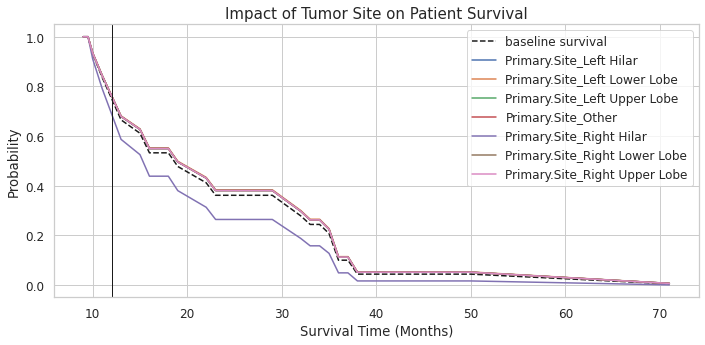

In [102]:
p_site_cols = ['Primary.Site_Left Hilar','Primary.Site_Left Lower Lobe','Primary.Site_Left Upper Lobe','Primary.Site_Other',
               'Primary.Site_Right Hilar','Primary.Site_Right Lower Lobe','Primary.Site_Right Upper Lobe']

plot_covariate_categories(train_final, p_site_cols, 'Tumor Site')

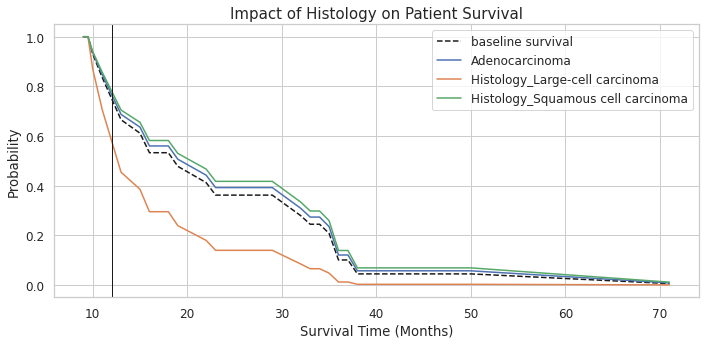

In [103]:
hist_cols = ['Adenocarcinoma','Histology_Large-cell carcinoma','Histology_Squamous cell carcinoma']
plot_covariate_categories(train_final, hist_cols, 'Histology')

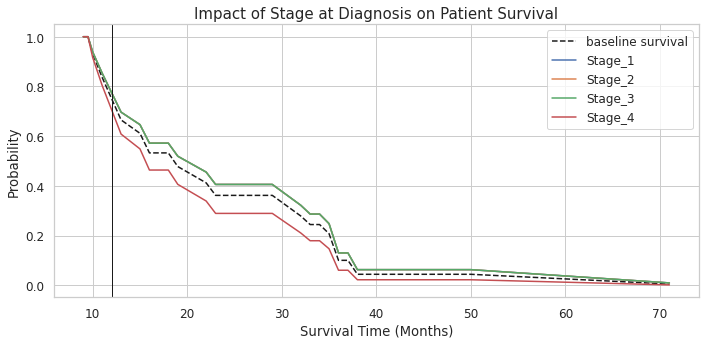

In [104]:
stage_cols = ['Stage_1','Stage_2','Stage_3','Stage_4']
plot_covariate_categories(train_final, stage_cols, 'Stage at Diagnosis')

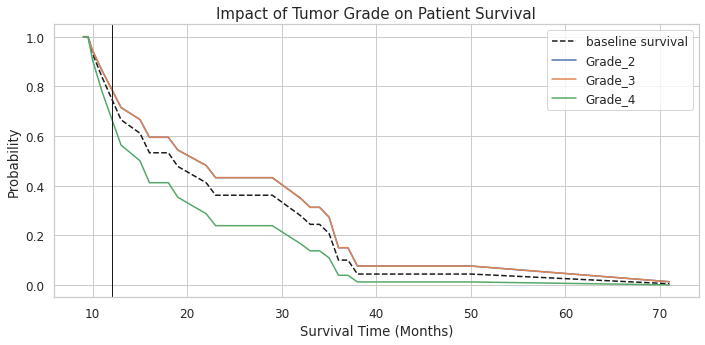

In [105]:
grade_cols = ['Grade_2','Grade_3','Grade_4']
plot_covariate_categories(train_final, grade_cols, 'Tumor Grade')

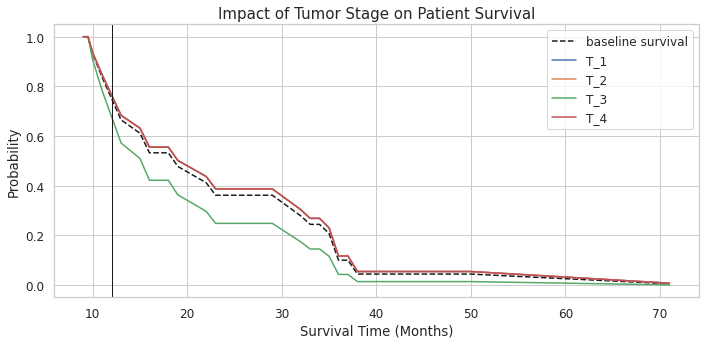

In [106]:
t_cols = ['T_1','T_2','T_3','T_4']
plot_covariate_categories(train_final, t_cols, 'Tumor Stage')

The plots show that tumor grade 2 and 3 have the greatest positive impact on survival. Conversely, large-cell carcinoma histology, tumor grade 4, tumor stage 3 and right hilar primary site affect survival negatively to an even greater extent. Of all the categorical covariates, tumor stage at diagnosis has the least impact on patient survival.

<br/>
Most of the features that I identified via correlation analysis made it into the final feaure set, and many of them have large coefficients. However, I examined the correlations for the entire dataset and did so prior to performing missing value imputation, which likely altered them to some extent. Also, the categorical features have some minor problems with interpretability that I went over previously. But as a whole, the feature set and its coefficients seem  relatively reasonable.

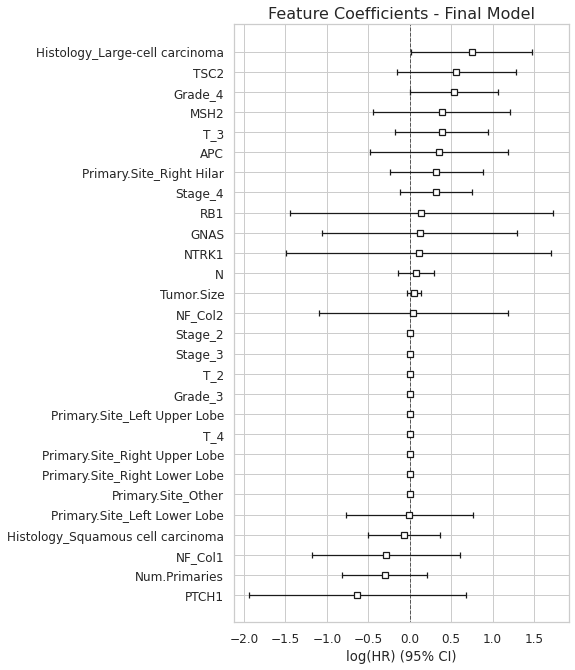

In [107]:
plt.figure(figsize=(6, 11))
plt.title('Feature Coefficients - Final Model', fontsize=16)
cph_final.plot();

In order to determine the most important features of the model as defined by hazard ratio, I scaled the numeric variables and performed minor calculations on the categorical variables and feature coefficients.

For example, I calculated the hazard ratio of the categorical feature Histology to be 2.25. The coefficents of the feature values are as follows: Large-cell carcinoma: 0.744, Adenocarcinoma: 0, and Squamous cell carcinoma: -0.069. The hazard ratio of Large-cell carcinoma with respect to Adenocarcinoma is $e^{0.744} =$ 2.10, while that of Squamous cell carcinoma with respect to Adenocarcinoma is $e^{-0.069} =$ 0.93. Finally, the hazard ratio of Large-cell carcinoma with respect to Squamous cell carcinoma (the largest hazard ratio among the feature values) is $e^{0.744 + 0.069} =$ 2.25. The interpretation is that a patient with Large-cell carcinoma has a hazard rate (probability of death occurring at time t, given it has not occurred yet) of 2.25 times that of a patient with Squamous cell carcinoma at all times.

The 10 most influential features of the model (by hazard ratio) are as follows:

Histology: 2.25, PTCH1: 0.53 (1.88), TSC2: 1.76, Tumor Grade: 1.71, Tumor Size: 1.59, MSH2: 1.47, Tumor Stage (T): 1.47, APC: 1.42, Primary Site: 1.39, and Stage at Diagnosis: 1.38.

In [108]:
cph_final.score(test_final, scoring_method='concordance_index')

0.7733333333333333

My model has performed well on multiple metrics all throughout training, validation, and testing, and it has shown that its performance is likely generalizable. Even so, the goal of this project is not only to build a predictive model of survival for non-small cell lung cancer, but to specifically predict one-year survival.<br/><br/>
The survival probability calibration plots below compare the predicted one-year mortality probabilities of my model against the observed probabilities. The smoothed calibration curve of a perfectly calibrated model would lie directly on the diagonal line, but the predicted probabilities of my model are higher than those observed for the one-year timeframe, to varying degrees. The calibration plots are somewhat misleading, since my model is generally better calibrated over the range of predicted probabilities where the majority of patients lie, as indicated by the bar graphs.<br/><br/>
ICI (Integrated Calibration Index) and E50 are provided as well. In my opinion, these are better metrics by which to measure survival model calibration. The ICI is the weighted difference between observed and predicted probabilities, in which observations are weighted by the empirical density function of the predicted probabilities. E50 represents the median absolute difference between observed and predicted probabilities. My model performed particularly well on the test set, with an ICI of 8.3 percent and an E50 of 6.7 percent. However, the model did not perform quite as well on the dataset as a whole, with ICI and E50 values of 11.6 and 11.3 percent respectively.<br/><br/>
While my model performs relatively well within the first year, it could be better calibrated for the specific timeframe. However, the one-year period is particularly difficult to predict, as a significant proportion of patients die close to the one-year mark (survival time of less than 12 or 12-18 months). This is shown below in the observed survival time distribution plots.

ICI =  0.08292183490450411
E50 =  0.06714531733443052


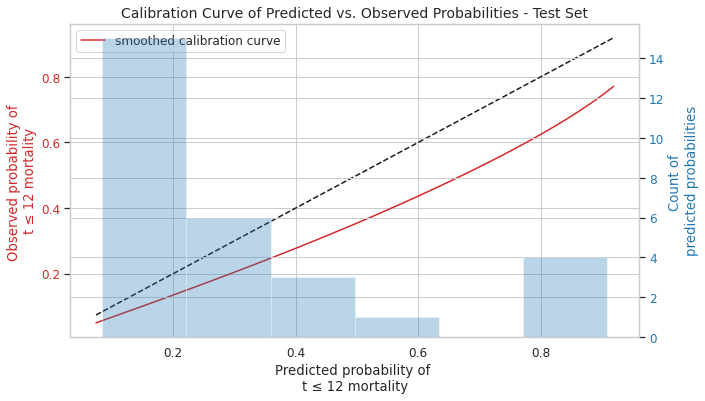

In [109]:
fig, ax = plt.subplots(figsize=(10, 6))
survival_probability_calibration(cph_final, test_final, t0=12, ax=ax);
ax.set_title('Calibration Curve of Predicted vs. Observed Probabilities - Test Set', fontsize=14);

In [110]:
# Create final complete dataset from train, validation, and test sets
dataset_final = pd.concat([train_final, val_final, test_final]).sort_index()

ICI =  0.11628238917134796
E50 =  0.11291056231756075


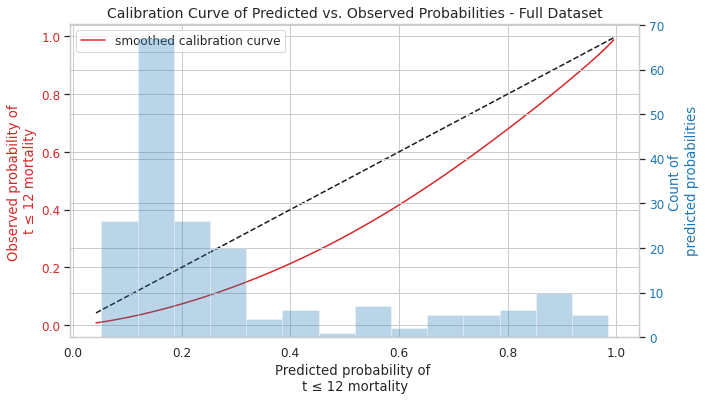

In [111]:
fig, ax = plt.subplots(figsize=(10, 6))
survival_probability_calibration(cph_final, dataset_final, t0=12, ax=ax);
ax.set_title('Calibration Curve of Predicted vs. Observed Probabilities - Full Dataset', fontsize=14);

These plots show the observed censored survival times of the test set and full dataset. As mentioned above, a significant proportion of patients die close to the one-year mark (black line).

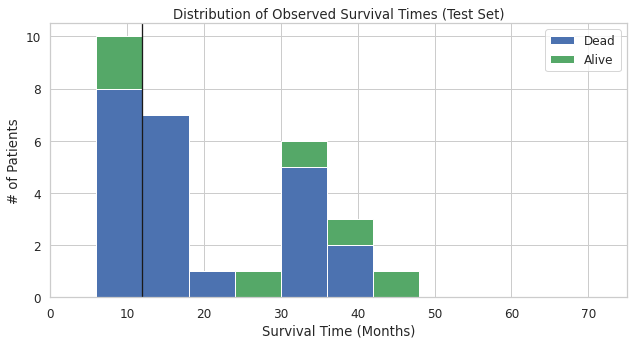

In [112]:
x = test_final[test_final.Outcome == 1]['Survival.Months']
y = test_final[test_final.Outcome == 0]['Survival.Months']
plt.figure(figsize=(9, 5))
plt.hist([x, y], bins=np.arange(0, 73, 6), stacked=True, color=['b', 'g'], label=['Dead', 'Alive'])
plt.legend()
plt.xlabel('Survival Time (Months)')
plt.xlim(0, 75)
plt.ylabel('# of Patients')
plt.title('Distribution of Observed Survival Times (Test Set)')
plt.axvline(12, color='k', linestyle='-', lw=1.3)
plt.tight_layout()

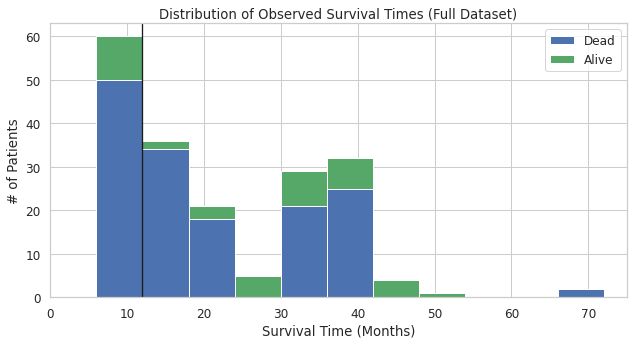

In [113]:
x = dataset_final[dataset_final.Outcome == 1]['Survival.Months']
y = dataset_final[dataset_final.Outcome == 0]['Survival.Months']
plt.figure(figsize=(9, 5))
plt.hist([x, y], bins=np.arange(0, 73, 6), stacked=True, color=['b', 'g'], label=['Dead', 'Alive'])
plt.legend()
plt.xlabel('Survival Time (Months)')
plt.xlim(0, 75)
plt.ylabel('# of Patients')
plt.title('Distribution of Observed Survival Times (Full Dataset)')
plt.axvline(12, color='k', linestyle='-', lw=1.3)
plt.tight_layout()

Finally, here are several graphs showing the baseline survival function, the survival curve for each patient for both the entire timeframe and the one-year period, and also the median survival predictions of each patient. It feels great to see my model in action after all this work!

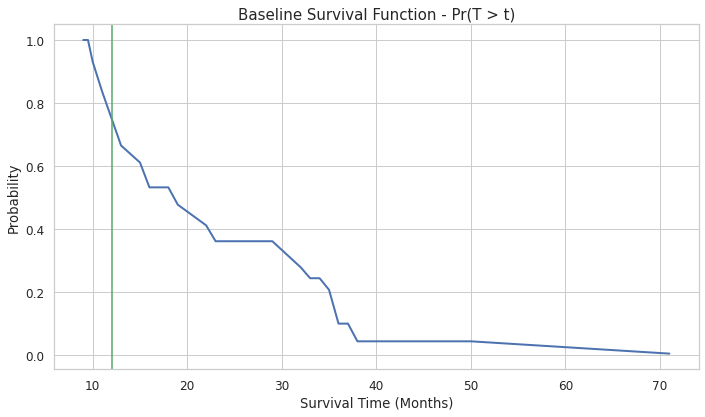

In [114]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(cph_final.baseline_survival_, linewidth=2)
ax.set_xlabel('Survival Time (Months)')
ax.set_ylabel('Probability')
ax.set_title('Baseline Survival Function - Pr(T > t)', fontsize=15)
ax.axvline(12, color='g', linestyle='-')
fig.tight_layout()

The one-year baseline survival probability is approximately 75%, while the median baseline survival time is approximately 18 months.

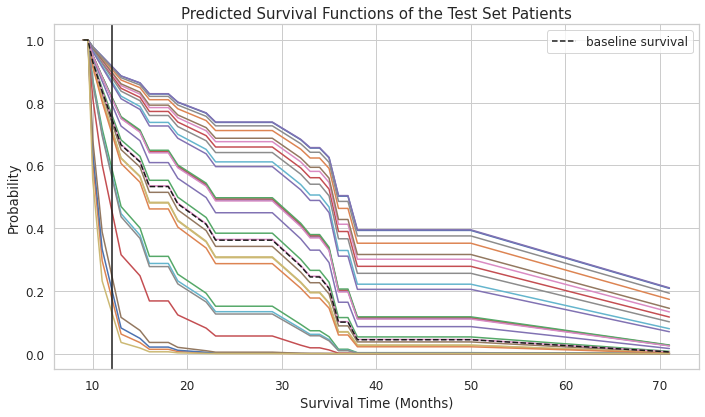

In [115]:
fig, ax = plt.subplots(figsize=(10, 6))
cph_final.predict_survival_function(test_final).plot(ax=ax, legend=False)
cph_final.baseline_survival_.plot(ax=ax, style='--', color='k')
ax.set_xlabel('Survival Time (Months)')
ax.set_ylabel('Probability')
ax.set_title('Predicted Survival Functions of the Test Set Patients', fontsize=15)
ax.axvline(12, color='k', linestyle='-')
fig.tight_layout()

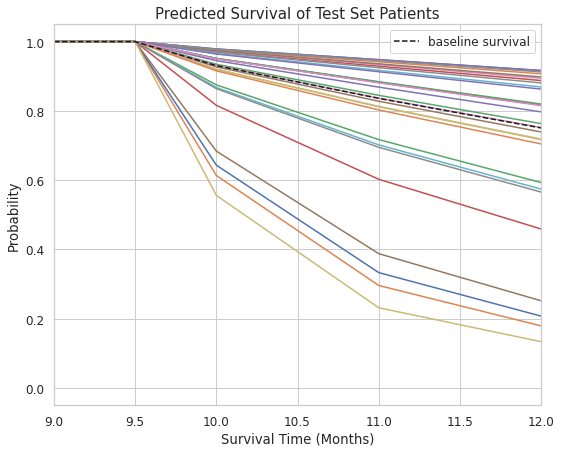

In [116]:
fig, ax = plt.subplots(figsize=(8, 6.5))
cph_final.predict_survival_function(test_final).plot(ax=ax, legend=False)
cph_final.baseline_survival_.plot(ax=ax, style='--', color='k')
ax.set_xlabel('Survival Time (Months)')
ax.set_ylabel('Probability')
ax.set_title('Predicted Survival of Test Set Patients', fontsize=15)
ax.set_xlim(9, 12)
fig.tight_layout()

The one-year survival probabilities of the test set patients have a wide range from approximately 15% to 90%.

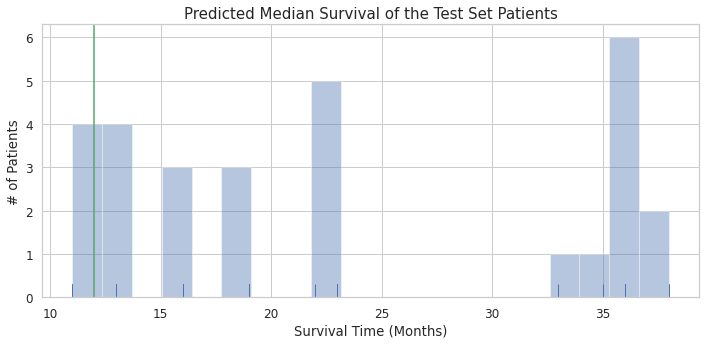

In [117]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.distplot(cph_final.predict_median(test_final), ax=ax, bins=20, kde=False, rug=True)
ax.set_xlabel('Survival Time (Months)')
ax.set_ylabel('# of Patients')
ax.set_title('Predicted Median Survival of the Test Set Patients', fontsize=15)
ax.axvline(12, color='g', linestyle='-')
fig.tight_layout()

Most of the test set patients seem to fall into 2 groups for predicted median survival time: approximately one and three years.
<br/><br/>

## Next Steps

I am very pleased with the results of my model, but it can certainly be improved. Going forward I would like to perform 5 or 10 fold cross-validation, possibly with repetition as well. While making the current model, I used 70-15-15 train-validation-test hold-out validation primarily for simplicity purposes. However, I made sure to use stratification when splitting the dataset to partially make up for the lack of cross-validation, used regularization to help reduce overfitting, and in the end, my tuned model was able to demonstrate generalizable high-level performance on the hold-out set.<br/><br/>
There are many difficulties associated with the implementation of cross-validation for this project. First of all, the datset requires imputation, and in order to perform imputation without data leakage, it must be performed within each fold of cross-validation. The dataset also has many near-zero variance features. If Cox proportional hazards regression is used, the model will fail when a feature has only one value in a given training fold, making quasi-constant features especially challenging to work with. Also, the lifelines package does not work seemlessly with scikit-learn, making functions like gridsearchcv especially difficult to use except in the simplest of cases. scikit-survival is probably the better option when performing techniques common to machine learning. In spite of these complications, I am confident that I can effectively implement cross-validaiton for this project going forward.<br/><br/>
I may also want to use and compare different types of survival regression models. In addition to Cox partial hazards regression, I could try Aalen's additive model as well as some of the many accelerated failure time models.<br/><br/>
Going forward, I would also want to perform more extensive feature engineering. While developing the current model, I primarily performed feature engineering on the categorical and ordinal variables. I combined some categories and created indicator variables out of the categorical/ordinal features. With more time, I could gain more domain knowledge of lung cancer with which to effectively choose and engineer features.<br/><br/>
Lastly, I would like to use either ICI (Integrated Calibration Index) or E50 as a scoring metric during validation or cross-validation. Unfortunately, I was unable to find their precise formulas while developing the current model. With these scoring metrics, I could make sure the specific timeframe of interest (the first year in this case) is calibrated as well as possible.<br/><br/>